# Titanic - Machine Learning from Disaster

## Import of necessary libraries

In [1]:
# Standard
import numpy as np
import pandas as pd
from time import time

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

# Save models imports
from joblib import dump, load

This is just for the final presentation, to make the notebook look nicer.

In [2]:
import warnings
warnings.filterwarnings("ignore")

##  Import data

Let's load our dataset like a DataFrame.

In [3]:
train = pd.read_csv('data/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's check shape of our data.

In [4]:
print(f"Train data (number of rows): {train.shape[0]}, (number of column): {train.shape[1]}")

Train data (number of rows): 891, (number of column): 12


## Dataset

Let's check information about our variables in dataset.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's check also every variables for missing values.

We see all variables which we have in our dataset. Not every variable has full set of values. They have also different types. 

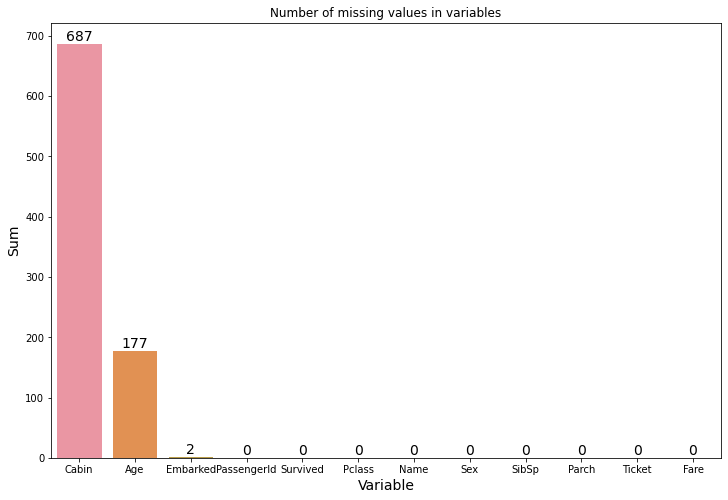

In [6]:
missing = pd.DataFrame(train.isnull().sum(),columns=['Sum']).sort_values(by=['Sum'],ascending=False).reset_index()
missing.columns = ['Variable','Sum']

plt.figure(figsize=(12,8))
plt.title('Number of missing values in variables')
ax = sns.barplot(x=missing.Variable,y=missing.Sum, data = missing)
ax.bar_label(ax.containers[0], fontsize=14);
plt.xlabel('Variable', size=14)
plt.ylabel('Sum', size=14)
plt.show()

Only three variables (Cabin, Age, Embarged) have a missing values.

Let's check unique values of each varieble.

In [7]:
pd.DataFrame(train.nunique(), columns=["Unique_values"])

,Unique_values
PassengerId,891
Survived,2
Pclass,3
Name,891
Sex,2
Age,88
SibSp,7
Parch,7
Ticket,681
Fare,248


Thanks to this simple query we can see how many unique values we have in each variable. There are variables for which all or almost all values are different.\
What's interesting is, the Fare variable has many different values, which means that ticket prices variet greatly. That is not a standard situation in public transport.

## EDA - Analysis of each variable

### Target variable - Survived

First we check target variable - Survived. What is a ratio of the number of people which survived to the number of people who died in the disaster. 

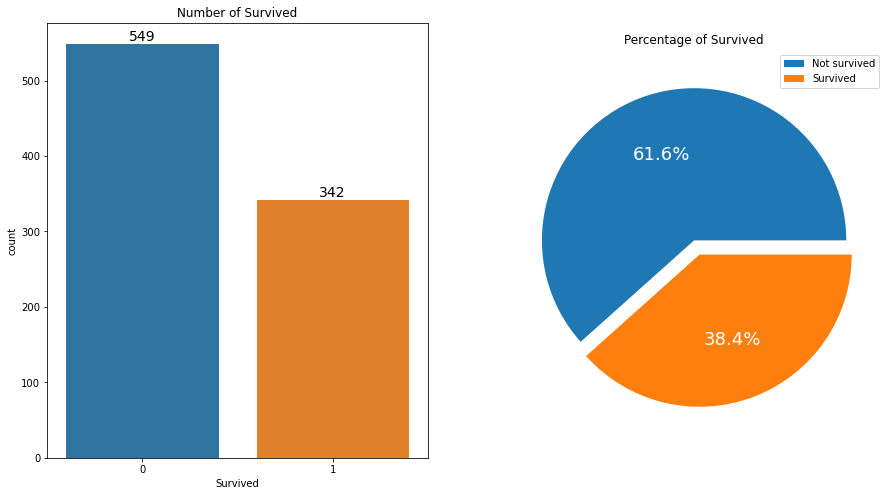

In [8]:
fig, axs = plt.subplots(figsize=(15,8), ncols=2)

ax = axs[0]
sns.countplot(x='Survived', data=train, ax=axs[0])
ax.set_title('Number of Survived')
ax.bar_label(ax.containers[0], fontsize=14);

ax = axs[1]
plt.pie(train['Survived'].value_counts(), labels=train['Survived'].unique(), autopct='%0.1f%%', explode=(0, 0.1), textprops={'fontsize': 18, 'color': "w"})
ax.set_title('Percentage of Survived')
ax.legend(['Not survived', 'Survived'])

plt.show()

**Conclusions to the variable:**

As we could expect, significantly fewer passengers survived the catastrophe.\
All of passengers are 891 in our dataset only 342 of them survived the disaster what is only 38%.

We should check every variables now to explain why some people were locky and they survived.\
Let's compare target variable with other e.g. sex, age or from which seaport they began their own jurney.

###  Types of explanatory variables

**<font size="3">Categorical variables</font>**

Categorical variables represent types of data that can be divided into groups. An example is gender, which can be categorized into two values (female and male).

**Categorical data in our dataset: Sex, Embarked**

**<font size="3">Ordinal variables</font>**

Ordinal variables are very similar to categorical variables. The difference between them is that their values are on an ordinal scale. They take values for which an order (sequence) is given, but it is not meaningful to determine the difference or ratio between two values.

**Ordinal data in our dataset: Pclass**

**<font size="3">Numeric variables</font>**

Numeric variables are features that can be measured on a ratio or interval scale. The simplest example of a continuous variable for a person would be their age.

**Numeric data in our dataset: Age, SibSp, Parch, Fare**

**<font size="3">Text variables</font>**

It happens that in our dataset we may encounter text variables. In such cases, it is usually necessary to transform these data for analysis. The most common form of a variable that is read as a text variable is time (date, hour).

**Text data in our dataset: Name**

#### Categorical variable &rarr; Sex

Let's perform a few checks on our variable **Sex**.

In [9]:
pd.DataFrame(train['Sex'].value_counts())

,Sex
male,577
female,314


In [10]:
pd.DataFrame(train.groupby(['Sex','Survived'])['PassengerId'].count())

PassengerId
Sex    Survived             
female 0                  81
       1                 233
male   0                 468
       1                 109

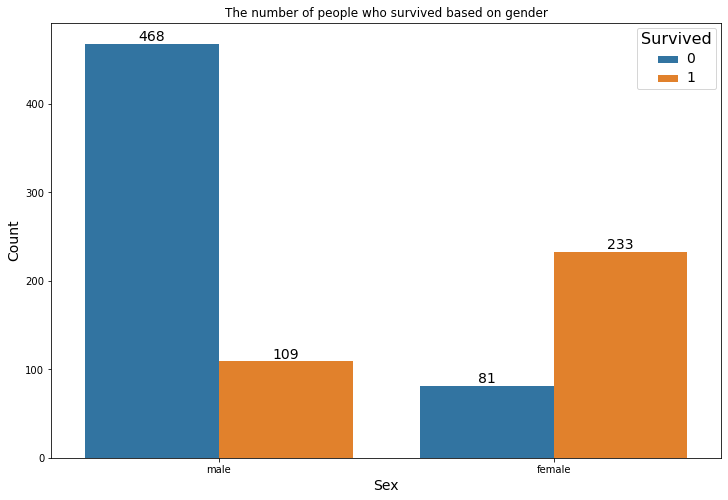

In [11]:
plt.figure(figsize=(12,8))
plt.title('The number of people who survived based on gender')
ax = sns.countplot(x='Sex', hue='Survived', data=train)

plt.xlabel('Sex', size=14)
plt.ylabel('Count', size=14)

# for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16')
plt.setp(ax.get_legend().get_texts(), fontsize='14')

for container in ax.containers:
    plt.bar_label(container, fontsize=14)

plt.show()

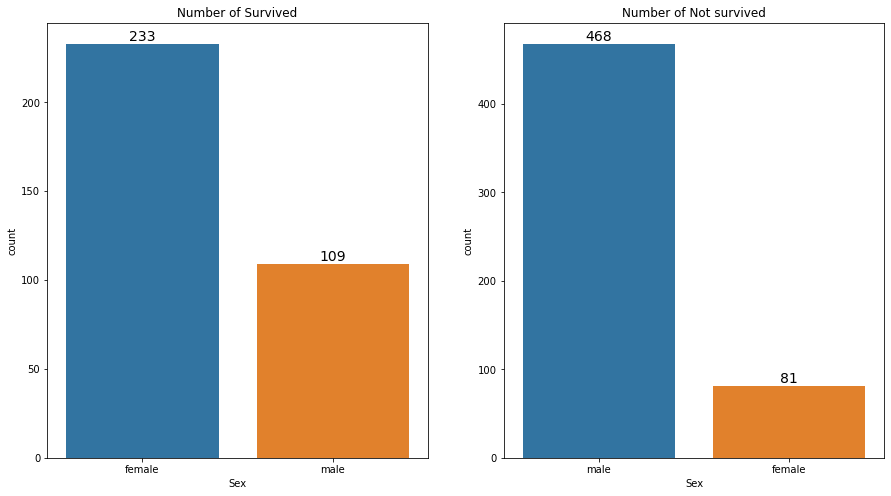

In [12]:
surv = pd.DataFrame(train[train["Survived"]==1]['Sex'])
not_surv = pd.DataFrame(train[train["Survived"]==0]['Sex'])

fig, axs = plt.subplots(figsize=(15,8), ncols=2)

ax = axs[0]
sns.countplot(x='Sex', data=surv, ax=axs[0])
ax.set_title('Number of Survived')
ax.bar_label(ax.containers[0], fontsize=14);

ax = axs[1]
sns.countplot(x='Sex', data=not_surv, ax=axs[1])
ax.set_title('Number of Not survived')
ax.bar_label(ax.containers[0], fontsize=14);

plt.show()

**Conclusions to the variable:**

Despite there being significantly more men on board the Titanic, 577 compared to only 314 women, twice as many women survived as men.\
Around 75% of all women survived, while fewer than 19% of men did.\
This statistic is very interesting. Gender variable can have a significant impact on one's chances of survival.

#### Categorical variables &rarr; Embarked

Let's verify the Embarked variable.

In [13]:
pd.DataFrame(train['Embarked'].value_counts())

,Embarked
S,644
C,168
Q,77


In [14]:
pd.crosstab([train.Embarked,train.Sex],[train.Survived], margins=True)

Survived           0    1  All
Embarked Sex                  
C        female    9   64   73
         male     66   29   95
Q        female    9   27   36
         male     38    3   41
S        female   63  140  203
         male    364   77  441
All              549  340  889

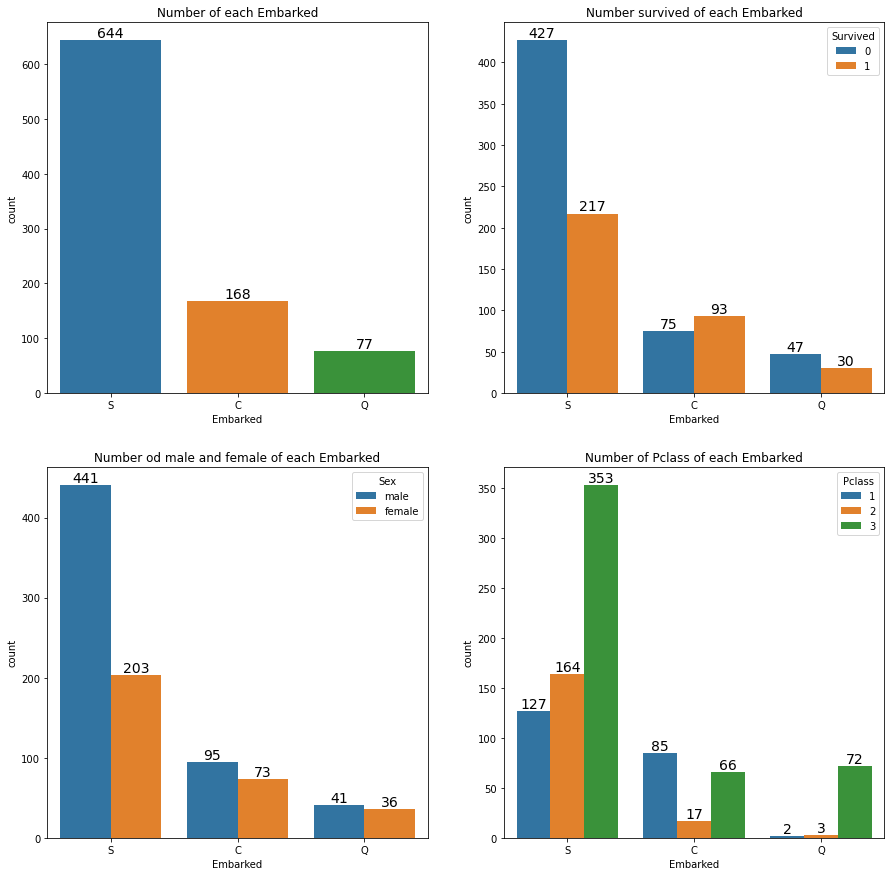

In [15]:
fig, axs = plt.subplots(figsize=(15,15), ncols=2, nrows=2)

ax1 = axs[0,0]
sns.countplot(x='Embarked', data=train, ax=ax1)
ax1.set_title('Number of each Embarked')
ax1.bar_label(ax1.containers[0], fontsize=14);

ax2 = axs[0,1]
sns.countplot(x='Embarked', data=train, hue="Survived", ax=ax2)
ax2.set_title('Number survived of each Embarked')
for container in ax2.containers:
    ax2.bar_label(container, fontsize=14)

ax3 = axs[1,0]
sns.countplot(x='Embarked', data=train, hue="Sex", ax=ax3)
ax3.set_title('Number od male and female of each Embarked')
for container in ax3.containers:
    ax3.bar_label(container, fontsize=14)


ax4 = axs[1,1]
sns.countplot(x='Embarked', data=train, hue="Pclass", ax=ax4)
ax4.set_title('Number of Pclass of each Embarked')
for container in ax4.containers:
    ax4.bar_label(container, fontsize=14)

plt.show()

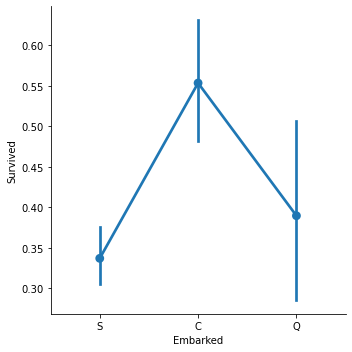

In [16]:
sns.catplot(x='Embarked', y='Survived', data=train, kind='point')

plt.show()

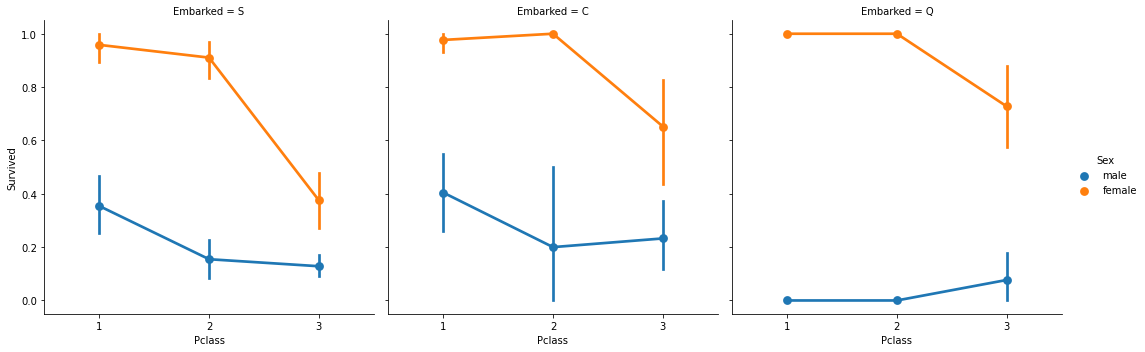

In [17]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=train, kind='point')

plt.show()

**Conclusions to the variable:**

The majority of passengers embarked from Southampton. They were mostly individuals who chose the lowest class, 3.\
More than twice as many men as women boarded in Southampton.\
Passengers from Cherbourg had the greatest fortune. It was the only port where the ratio of survivors was positive.\
Due to the fact that Southampton had the most passengers boarding there, it also had the highest number of wealthy individuals who purchased first and second class tickets.\
In Queenstown, nearly all passengers chose third class — approximately 95%.\
Those who boarded in Cherbourg had the highest chances of survival, around 0.55, whereas those from Southampton had the lowest chances.\
The probability of survival was nearly 1 for women in first and second class, regardless of their port of embarkation.\
Southampton was the least fortunate for third-class passengers, both men and women.\
Queenstown appears to be the least fortunate for men, with very low survival probabilities.

##### Imputing missing values in Embarked

We see that the majority of passengers boarded at Southampton, so we will replace the NaN values with 'S'.

In [18]:
train['Embarked'].fillna('S',inplace=True)

In [19]:
train.Embarked.isnull().sum()

0

#### Ordinal variables &rarr; Pclass

Let's now analyze our only ordinal variable - **Pclass** (Passenger Class).

In [20]:
pd.DataFrame(train['Pclass'].value_counts())

,Pclass
3,491
1,216
2,184


In [21]:
pd.crosstab([train.Sex,train.Pclass],[train.Survived], margins=True)

Survived         0    1  All
Sex    Pclass               
female 1         3   91   94
       2         6   70   76
       3        72   72  144
male   1        77   45  122
       2        91   17  108
       3       300   47  347
All            549  342  891

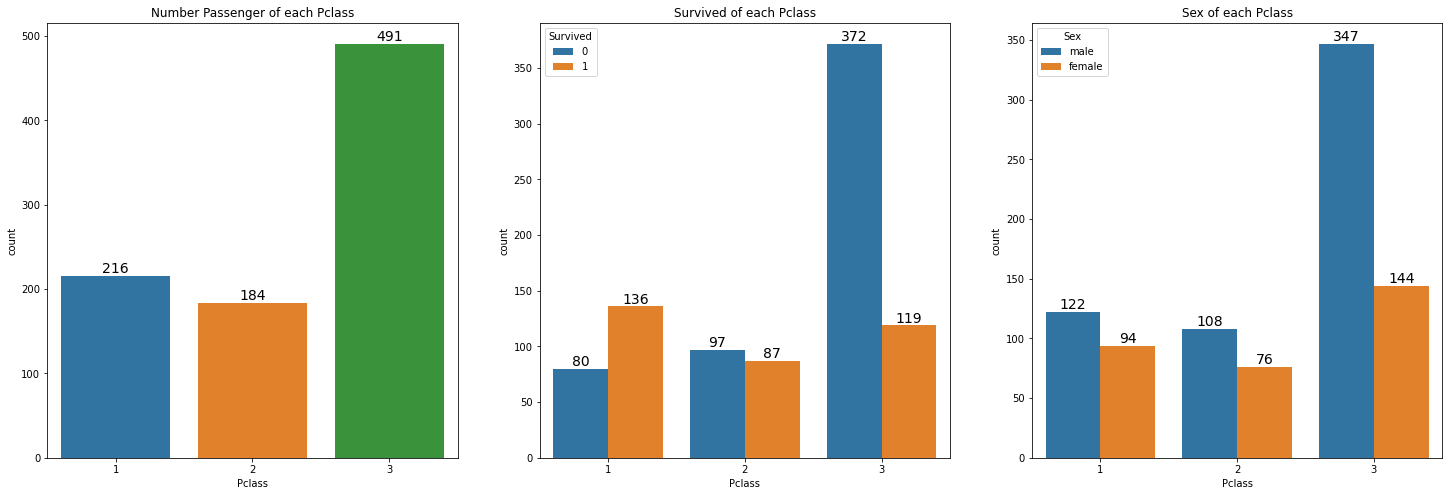

In [22]:
fig, axs = plt.subplots(figsize=(25,8), ncols=3)

ax1 = axs[0]
ax = sns.countplot(x='Pclass', data=train, ax=ax1)
ax1.set_title('Number Passenger of each Pclass')
ax.bar_label(ax.containers[0], fontsize=14);

ax2 = axs[1]
ax = sns.countplot(x='Pclass', data=train, hue='Survived', ax=ax2)
ax2.set_title('Survived of each Pclass')
sns.move_legend(ax, "upper left")
for container in ax2.containers:
    ax2.bar_label(container, fontsize=14);

ax3 = axs[2]
ax = sns.countplot(x='Pclass', data=train, hue='Sex', ax=ax3)
ax3.set_title('Sex of each Pclass')
sns.move_legend(ax, "upper left")
for container in ax3.containers:
    ax3.bar_label(container, fontsize=14);

plt.show()

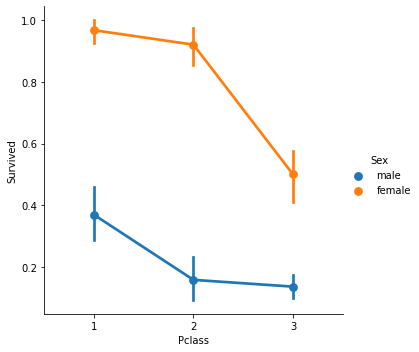

In [23]:
sns.catplot(x='Pclass',y='Survived',hue='Sex', kind='point', data=train)

plt.show()

**Conclusions to the variable:**

We can see that the survival rate in the first and second classes was significantly higher compared to the third class. In the first class, almost 63% survived, in the second class 47%, while in the third class only 24% survived.\
It's evident that survival among women in the first and second classes was highest, as only 9 out of 170 women from these classes perished. It appears that women from the first and second classes were given priority during evacuation. Men did not receive this priority, as their survival rate is exceptionally low.\
Pclass is another variable that can have a significant impact on predicting the target variable.

#### Numeric variables &rarr; Age

Let's check the variable **Age** of the passengers.

In [24]:
pd.DataFrame(train['Age'].describe())

,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


In [25]:
print('Oldest Passenger was of:',train['Age'].max(),'Years')
print('Youngest Passenger was of:',train['Age'].min(),'Years')
print('Average Age on the ship:',round(train['Age'].mean(),2),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.7 Years


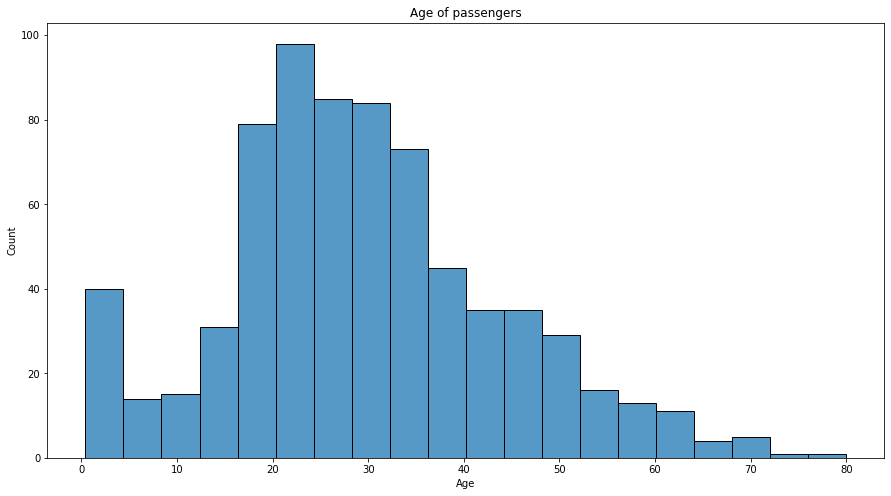

In [26]:
fig = plt.subplots(figsize=(15,8))

ax = sns.histplot(x='Age', data=train)
plt.title('Age of passengers')

plt.show()

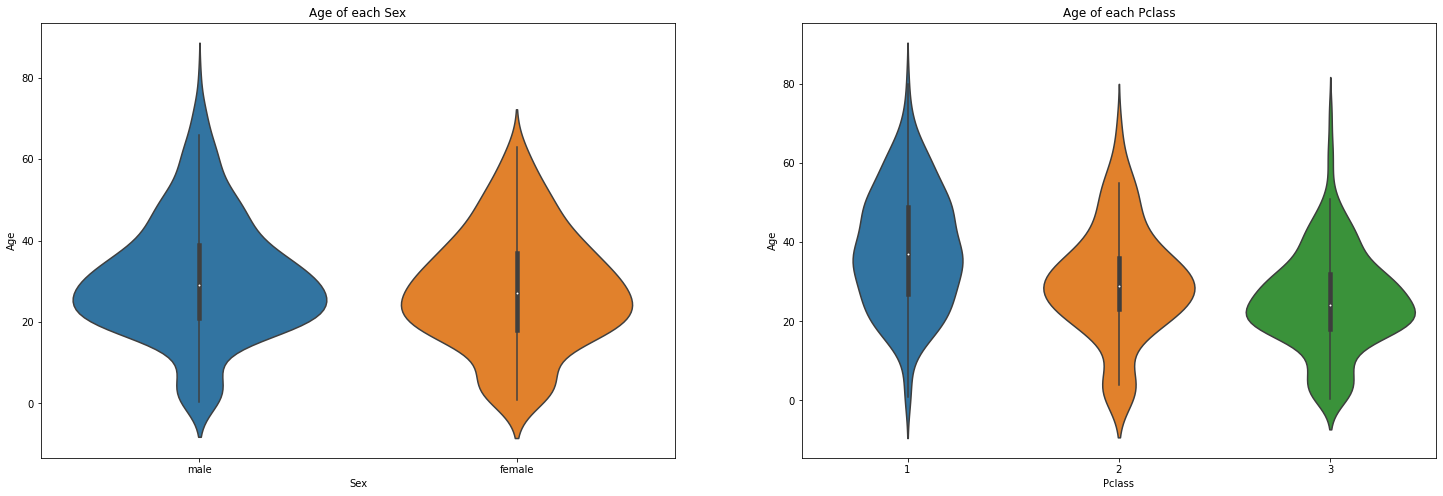

In [27]:
fig, axs = plt.subplots(figsize=(25,8), ncols=2)

ax1 = axs[0]
ax = sns.violinplot(x="Sex", y="Age", data=train, split=True, ax=ax1)
ax.set_title('Age of each Sex')

ax2 = axs[1]
ax = sns.violinplot(x="Pclass", y="Age", data=train, split=True, ax=ax2)
ax2.set_title('Age of each Pclass')

plt.show()

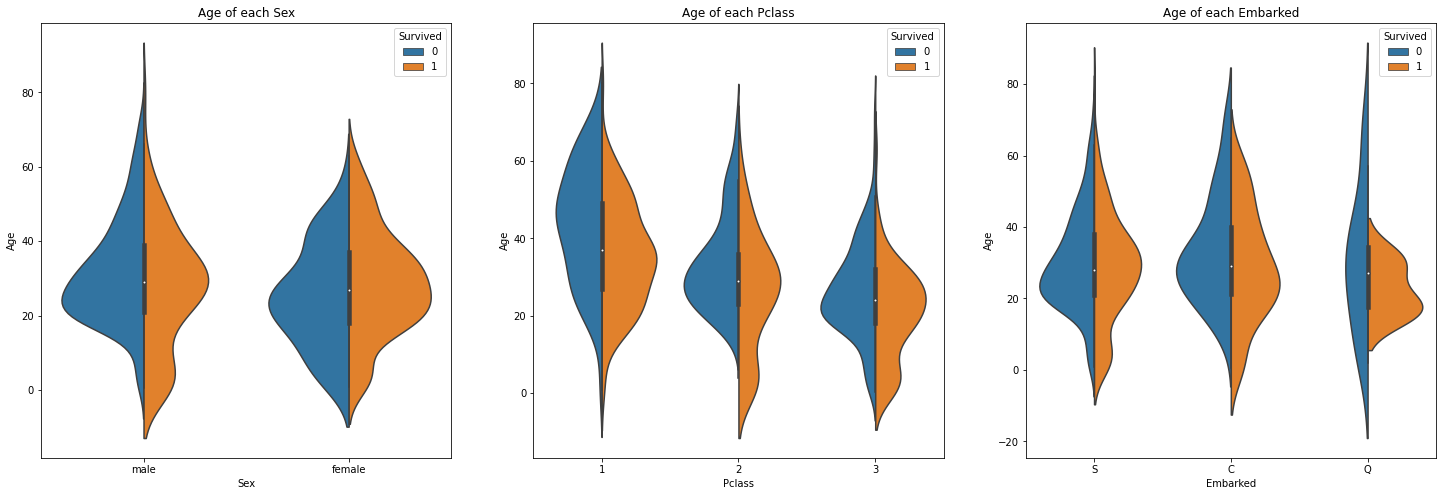

In [28]:
fig, axs = plt.subplots(figsize=(25,8), ncols=3)

ax1 = axs[0]
ax = sns.violinplot(x="Sex", y="Age", hue="Survived", data=train, split=True, ax=ax1)
ax.set_title('Age of each Sex')

ax2 = axs[1]
ax = sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train, split=True, ax=ax2)
ax2.set_title('Age of each Pclass')

ax3 = axs[2]
ax = sns.violinplot(x="Embarked", y="Age", hue="Survived", data=train, split=True, ax=ax3)
ax3.set_title('Age of each Embarked')

plt.show()

**Conclusions to the variable:**

There are more children on the ship among passengers in lower classes. However, despite this, we can see that the survival rate is quite high.\
It's evident that individuals aged 20-40 had better chances of survival. Women in this age range even had higher chances than men.\
The older a person is, the more likely they chose a higher class, likely due to greater wealth among older individuals.

There are 177 missing values in our age variable that need to be replaced with another value.\
One option is to fill these gaps with the average age value for the remaining people. However, the problem is that there are too many different values and the range of our values is very large. We could mistakenly assign the average value of 29 years to a very young or older person.

We need to continue looking at our data. Perhaps other variables will help us better fill in the missing values in the Age variable.

#### Numeric variables &rarr; SibSp

The dataset defines family relationships as follows:

Sibling = brother, sister, stepbrother, stepsister\
Spouse = husband, wife (excluding lovers and fiancés)

In [29]:
pd.DataFrame(train['SibSp'].value_counts().sort_index())

,SibSp
0,608
1,209
2,28
3,16
4,18
5,5
8,7


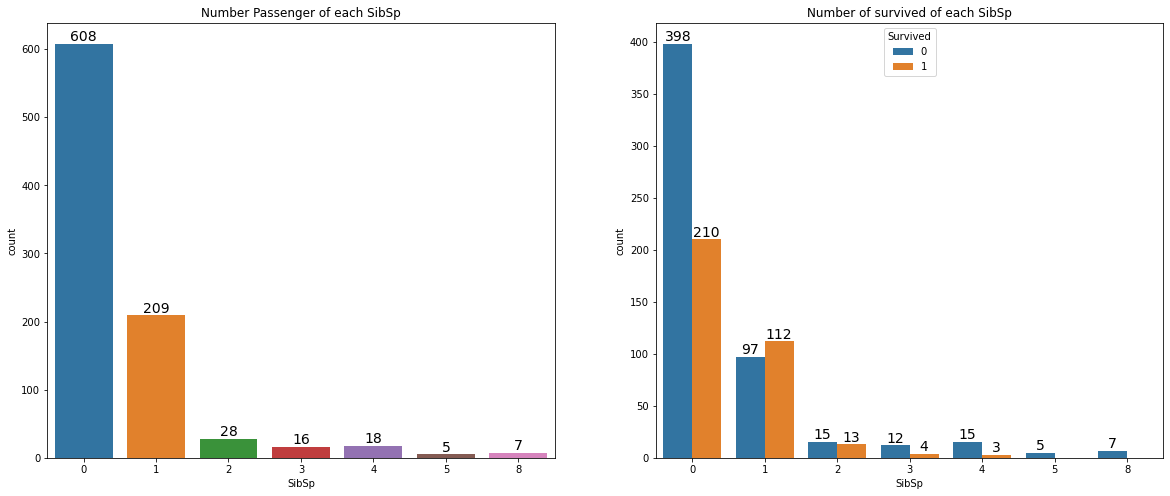

In [30]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2)

ax1 = axs[0]
ax = sns.countplot(x='SibSp', data=train, ax=ax1)
ax.set_title('Number Passenger of each SibSp')
ax.bar_label(ax.containers[0], fontsize=14);

ax2 = axs[1]
ax = sns.countplot(x='SibSp', data=train, hue='Survived', ax=ax2)
ax2.set_title('Number of survived of each SibSp')
for container in ax2.containers:
    ax2.bar_label(container, fontsize=14);

plt.show()

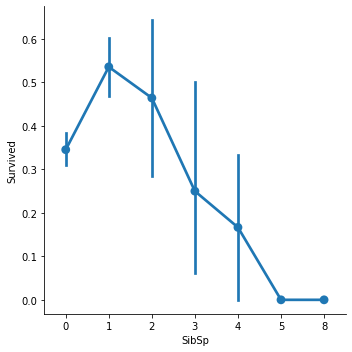

In [31]:
ax = sns.catplot(x='SibSp',y='Survived', kind='point', data=train)

plt.show()

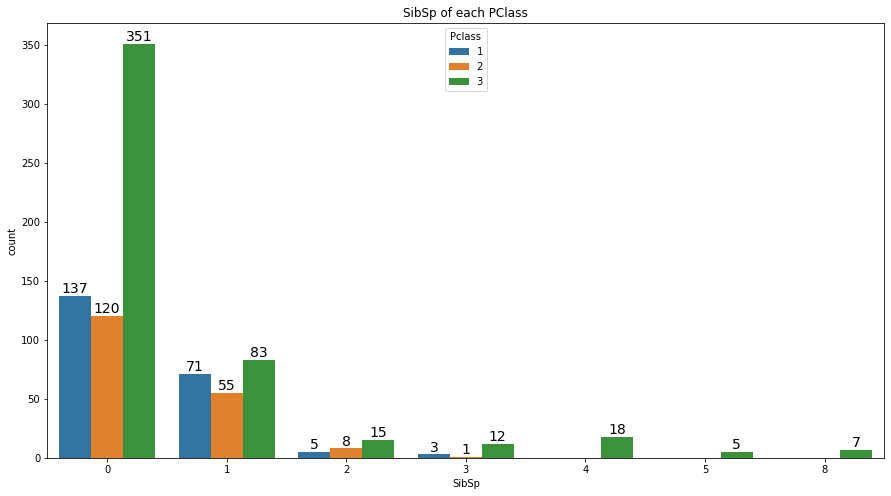

In [32]:
fig = plt.subplots(figsize=(15,8))

ax = sns.countplot(x='SibSp', data=train, hue='Pclass')
plt.title('SibSp of each PClass')
sns.move_legend(ax, "upper center")

for container in ax.containers:
    plt.bar_label(container, fontsize=14);

plt.show()

**Conclusions to the variable:**

The vast majority traveled alone or with only one sibling.\
Individuals traveling without siblings had a 34.5% chance of survival.\
None of the families with 5 or 8 siblings survived the disaster.\
Families with 3 or more siblings were mainly in third class, which, as we know from the Pclass analysis, could have had a significant impact on their low survival rate.\
Almost 58% of all individuals traveling without siblings chose third class.

#### Numeric variables &rarr; Parch

The dataset defines family relationships as follows:

Parent = mother, father\
Child = daughter, son, stepdaughter, stepson
Some children traveled only with a nanny, so for them, the value is set to 0.

In [33]:
pd.DataFrame(train['Parch'].value_counts().sort_index())

,Parch
0,678
1,118
2,80
3,5
4,4
5,5
6,1


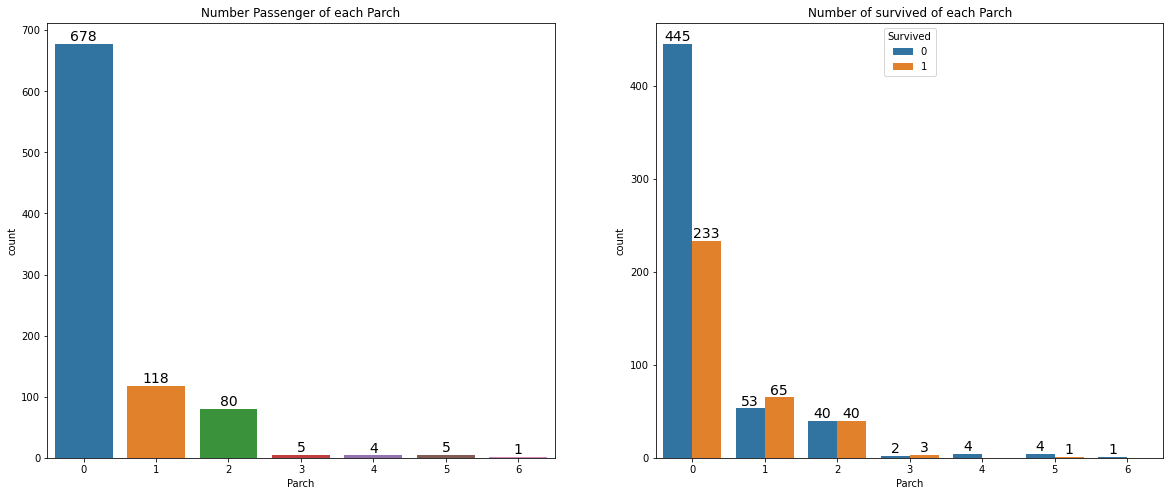

In [34]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2)

ax1 = axs[0]
ax = sns.countplot(x='Parch', data=train, ax=ax1)
ax.set_title('Number Passenger of each Parch')
ax.bar_label(ax.containers[0], fontsize=14);

ax2 = axs[1]
ax = sns.countplot(x='Parch', data=train, hue='Survived', ax=ax2)
ax2.set_title('Number of survived of each Parch')
sns.move_legend(ax, "upper center")
for container in ax2.containers:
    ax2.bar_label(container, fontsize=14);
    

plt.show()

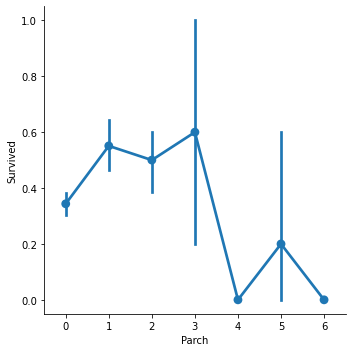

In [35]:
ax = sns.catplot(x='Parch',y='Survived', kind='point', data=train)

plt.show()

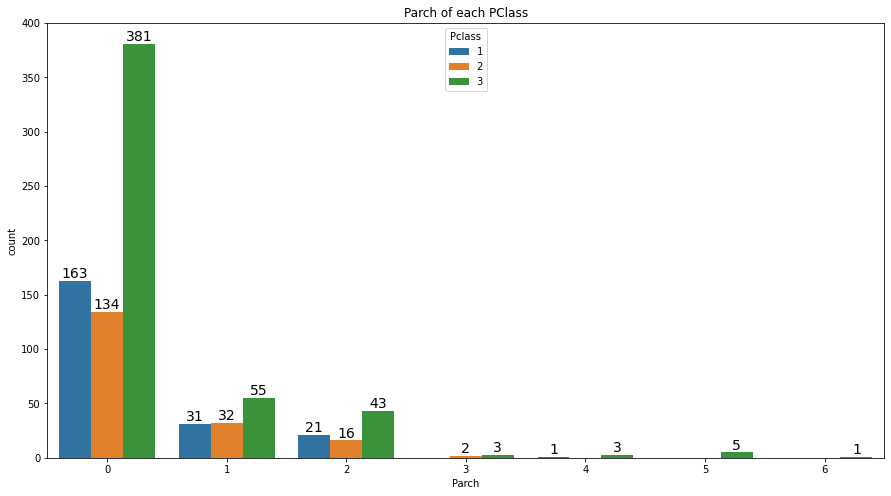

In [36]:
fig = plt.subplots(figsize=(15,8))

ax = sns.countplot(x='Parch', data=train, hue='Pclass')
plt.title('Parch of each PClass')
sns.move_legend(ax, "upper center")

for container in ax.containers:
    plt.bar_label(container, fontsize=14);

plt.show()

**Conclusions to the variable:**

The vast majority still traveled without a spouse.\
Large families, similarly to siblings, traveled in third class.\
As the family size increases, the probability of survival decreases. The chance of survival is good for families with 1-3 members.\
Families with more than 4 members had very low survival chances.\
Solo travelers had less than a 40% chance of survival.

#### Numeric variables &rarr; Fare

Let's check the variable **Fare**.

In [37]:
pd.DataFrame(train['Fare'].describe())

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200


In [38]:
print('Highest Fare was:',round(train['Fare'].max(),2))
print('Lowest Fare was:',round(train['Fare'].min(),2))
print('Average Fare was:',round(train['Fare'].mean(),2))

Highest Fare was: 512.33
Lowest Fare was: 0.0
Average Fare was: 32.2


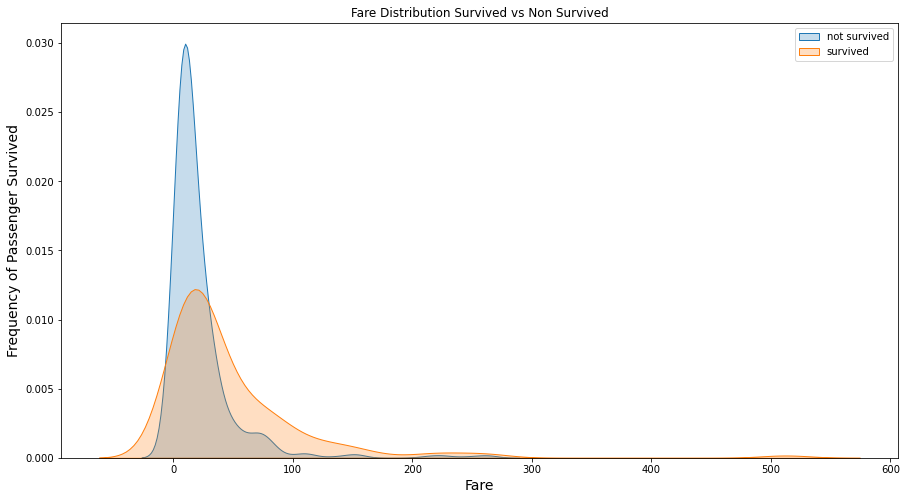

In [39]:
fig = plt.figure(figsize=(15,8))

ax=sns.kdeplot(train.loc[(train['Survived'] == 0),'Fare'], shade=True, label='not survived')
ax = sns.kdeplot(train.loc[(train['Survived'] == 1),'Fare'], shade=True, label='survived')
ax.set_title('Fare Distribution Survived vs Non Survived')
ax.set_ylabel("Frequency of Passenger Survived", fontsize = 14)
ax.set_xlabel("Fare", fontsize = 14);
ax.legend()

plt.show()

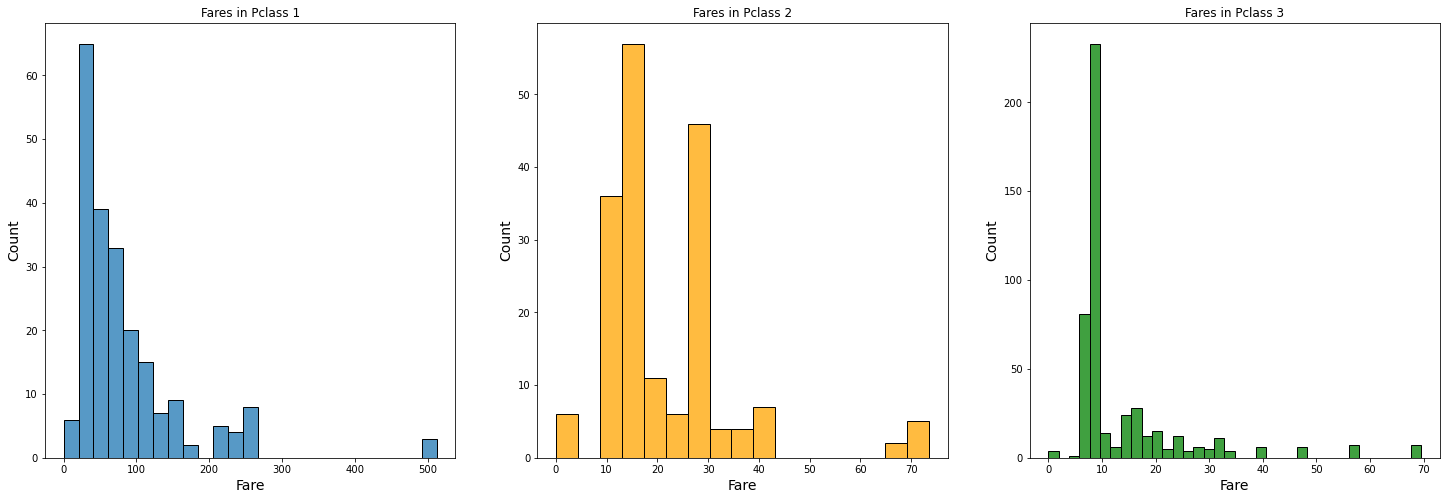

In [40]:
fig, axs = plt.subplots(figsize=(25,8), ncols=3)

ax1 = axs[0]
ax=sns.histplot(train[train['Pclass']==1].Fare, ax=ax1)
ax.set_title('Fares in Pclass 1')
ax.set_ylabel("Count", fontsize = 14)
ax.set_xlabel("Fare", fontsize = 14)

ax2 = axs[1]
ax=sns.histplot(train[train['Pclass']==2].Fare, color='orange', ax=ax2)
ax.set_title('Fares in Pclass 2')
ax.set_ylabel("Count", fontsize = 14)
ax.set_xlabel("Fare", fontsize = 14)

ax3 = axs[2]
ax=sns.histplot(train[train['Pclass']==3].Fare, color='g', ax=ax3)
ax.set_title('Fares in Pclass 3')
ax.set_ylabel("Count", fontsize = 14)
ax.set_xlabel("Fare", fontsize = 14)

plt.show()

**Conclusions to the variable:**

The fare for third class tickets mostly did not exceed \\$10.\
Tickets with a fare value greater than \\$300 are likely erroneous values.\
There are tickets with a fare of \\$0. These might also be erroneous or could represent tickets distributed for free or won, for example, in a lottery.

#### Text variables &rarr; Name

In [41]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The variable **Name**, which contains the names and surnames of individuals who traveled on the Titanic, may seem unnecessary at first glance. However, upon closer inspection, we see that after the comma there is a courtesy title that informs us about the marital status of the person, among other things. This allows us to infer the age range of that person.

To extract the courtesy title, we will use a regex pattern: **"([A-Za-z]+)\."**.\
This regex extracts all words that are followed by **. (kropka)**.

In [42]:
train['Initial']=''

for i in train:
    train['Initial']=train['Name'].str.extract('([A-Za-z]+)\.')

In [43]:
pd.DataFrame(train['Initial'].value_counts())

,Initial
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2
Countess,1


In [44]:
pd.set_option('display.max_columns', None)
pd.crosstab([train.Sex],[train.Initial], margins=True)

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,All
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0,314
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1,577
All,1,2,1,1,7,1,1,2,40,182,2,1,517,125,1,6,1,891


We will correct courtesy titles such as "Mlle" or "Mme", which mean "Miss", to their correct values.

We will categorize courtesy titles into 5 groups:
1) Master - indicating boys or young men (unmarried)\
2) Miss - young girls or unmarried women\
3) Mr - adult men\
4) Mrs - married women\
5) Other - other titles or honorary titles

In [45]:
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                         ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

##### Imputing missing values in Age

Courtesy titles allow us to divide the age variable into groups and determine the average age within each group.\
This will enable us to fill missing values in the Age variable much more effectively than using the average age for the entire dataset.

In [46]:
round(train.groupby('Initial')['Age'].mean(),2)

Initial
Master     4.57
Miss      21.86
Mr        32.74
Mrs       35.98
Other     45.89
Name: Age, dtype: float64

In [47]:
train.loc[(train.Age.isnull())&(train.Initial=='Master'),'Age']=5
train.loc[(train.Age.isnull())&(train.Initial=='Miss'),'Age']=22
train.loc[(train.Age.isnull())&(train.Initial=='Mr'),'Age']=33
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'),'Age']=36
train.loc[(train.Age.isnull())&(train.Initial=='Other'),'Age']=46

In [48]:
train.Age.isnull().sum()

0

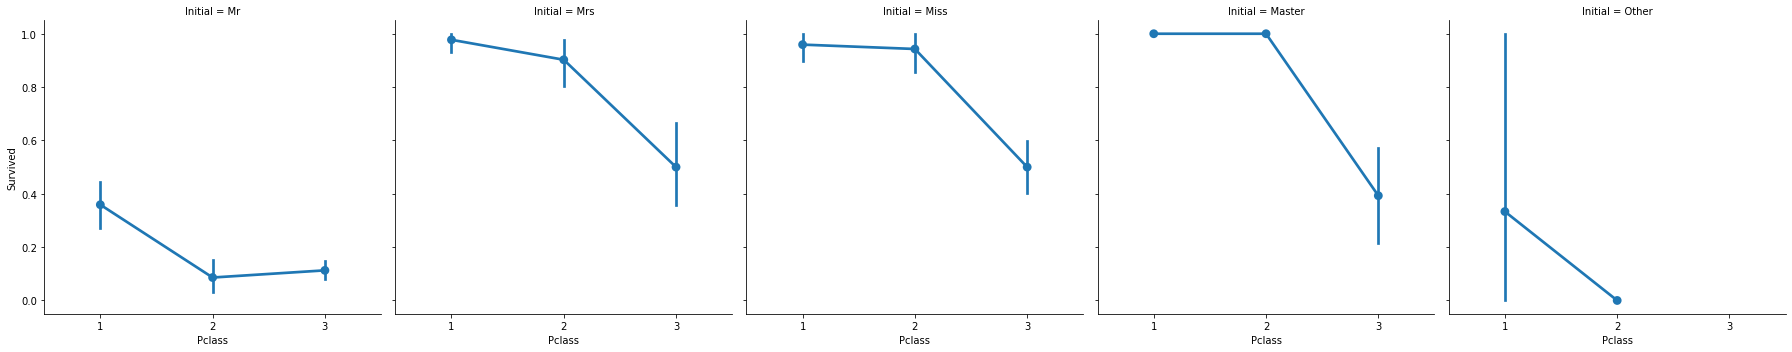

In [49]:
sns.catplot(x='Pclass', y='Survived', col='Initial', data=train, kind='point')

plt.show()

**Conclusions to the variable:**

We can see that women and children were given priority during the evacuation of the sinking ship. Their survival chances were higher compared to men, regardless of the class they traveled in.\
Individuals with honorary titles were undoubtedly wealthy, as they traveled exclusively in first and second class.

### Conclusions for all variables

**<font size="3">Sex:</font>** Women had a higher chance of survival. Women and children likely had priority during the evacuation.

**<font size="3">Embarked:</font>** Most passengers embarked from Southampton. The survival rate was higher for passengers who embarked from Cherbourg, despite most choosing first class in Southampton. Passengers from Queenstown predominantly chose the cheapest class.

**<font size="3">Pclass:</font>** It is evident that higher class passengers had better survival chances. Third class passengers had very low survival rates. Women in first and second class had nearly 100% survival rates.

**<font size="3">Age:</font>** Children under 10 years old had very high chances of survival. Older individuals, especially in third class, had lower survival chances.

**<font size="3">SibSp i Parch:</font>** Passengers traveling without siblings had lower chances than those with 1-2 siblings. Traveling with a large number of relatives resulted in very low survival chances. Traveling alone also had low survival chances.

### EDA - Correlation between the variables

Let's check how correlated our variables are with each other.

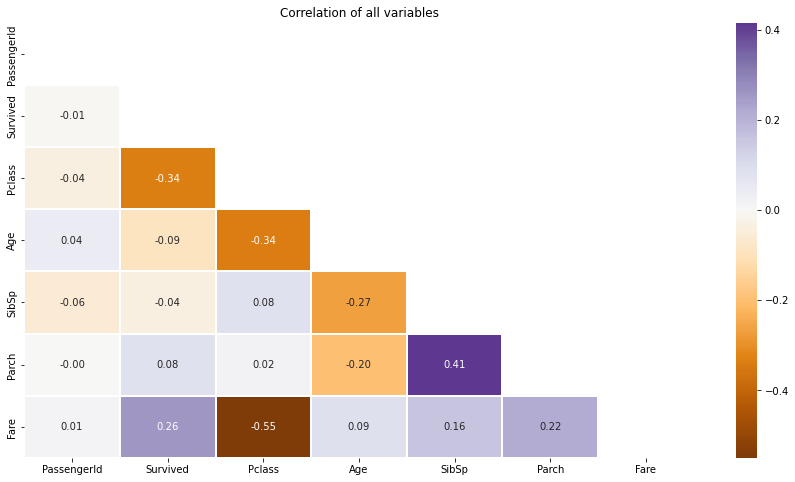

In [50]:
# Creat mask
mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True

# Heatmap of correlation
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), mask=mask, annot=True, cmap ='PuOr', square=False, linewidths=0.4, fmt=".2f", center=0)
plt.title("Correlation of all variables")
plt.show()

**Conclusions from the correlation matrix:**

The correlation matrix shows that there are no strong correlations between individual pairs of variables.\
The highest correlation is between **SibSp and Parch at 0.41**, and **Pclass and Fare at -0.55**.\
However, these correlations are too low to indicate multicollinearity, where both variables contain highly similar information and there is very little variance in the information.

## Feature Engineering and Data Cleaning

Not all variables in a given dataset are always necessary for use. Our dataset contains too many variables that we should eliminate. We can also derive or add new variables based on existing ones, such as extracting information from other variables.

Some of these variables have already been created, for example, the Initial variable derived from the Name variable. Let's see if we can obtain new variables and eliminate some unnecessary ones. We will also transform existing significant features into suitable forms for predictive modeling.

### Convert Age to Age_band

**Why should we transform the Age column:**

The Age variable is a continuous variable. In machine learning models, there are certain challenges with this type of data. Due to the wide range of different values in the Age variable, we should convert it from continuous to categorical. We can do this by grouping values.

The age range in our dataset spans from 0 to 80 years. Let's divide this range into 5 equal-sized groups based on interval sizes. We will split our datasets every 16 years, as 80 divided by 5 equals 16.

In [51]:
train['Age_band'] = 0

In [52]:
train.loc[train['Age'] <= 16,'Age_band'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32),'Age_band'] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48),'Age_band'] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64),'Age_band'] = 3
train.loc[train['Age'] > 64,'Age_band'] = 4

In [53]:
pd.DataFrame(train['Age_band'].value_counts().sort_index())

,Age_band
0,104
1,382
2,325
3,69
4,11


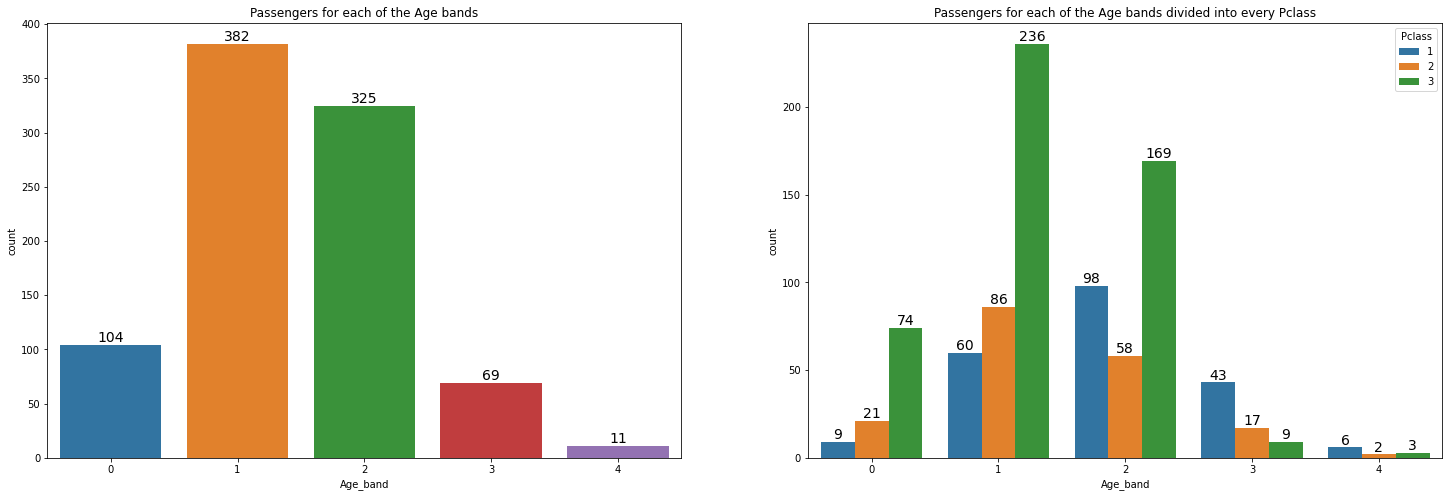

In [54]:
fig, axs = plt.subplots(figsize=(25,8), ncols=2)

ax1 = axs[0]
ax = sns.countplot(x='Age_band', data=train, ax=ax1)
ax1.set_title('Passengers for each of the Age bands')
ax.bar_label(ax.containers[0], fontsize=14);

ax2 = axs[1]
ax = sns.countplot(x='Age_band', hue="Pclass", data=train, ax=ax2)
ax2.set_title('Passengers for each of the Age bands divided into every Pclass')
for container in ax2.containers:
    ax2.bar_label(container, fontsize=14);

plt.show()

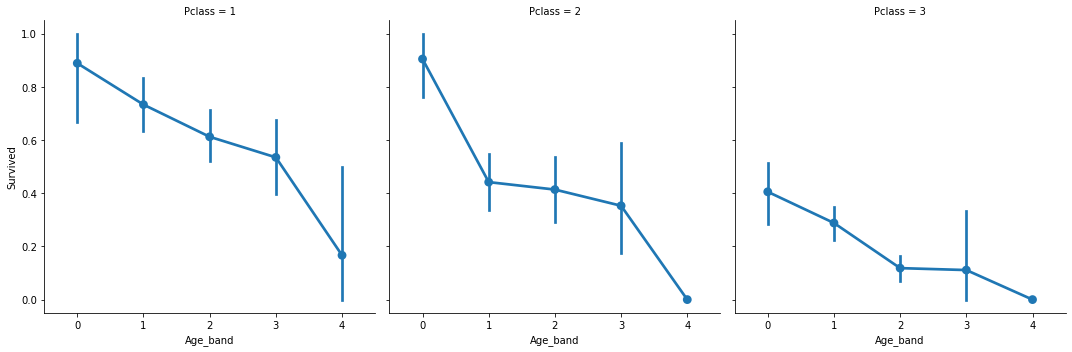

In [55]:
sns.catplot(x='Age_band', y='Survived', col='Pclass', data=train, kind='point')

plt.show()

**Conclusions to the variable:**

The majority of people were in the age range of 16 to 32 years old, while there were few individuals above 64 years old.\
The chances of surviving the disaster decrease with age, regardless of the passenger class.

### Calculate the size of family

**Why should we transform the SibSp and Parch columns:**

When we analyzed these two variables individually, we found similar conclusions, indicating that they provide similar types of information. We can create new categorical variables based on them.

Let's create two new variables:\
**Family_size:** This will be the sum of SibSp and Parch. It will tell us the total size of the family a person was traveling with.\
**Alone:** This variable will have two values: **0** if the person traveled alone without siblings, spouses, or parents, and **1** if they did not travel alone.

In [56]:
train['Family_size'] = 0
train['Alone'] = '0'

In [57]:
train['Family_size'] = train['SibSp'] + train['Parch']
train.loc[train['Family_size'] == 0,'Alone'] = '1'

In [58]:
pd.DataFrame(train['Family_size'].value_counts().sort_index())

,Family_size
0,537
1,161
2,102
3,29
4,15
5,22
6,12
7,6
10,7


In [59]:
pd.DataFrame(train['Alone'].value_counts())

,Alone
1,537
0,354


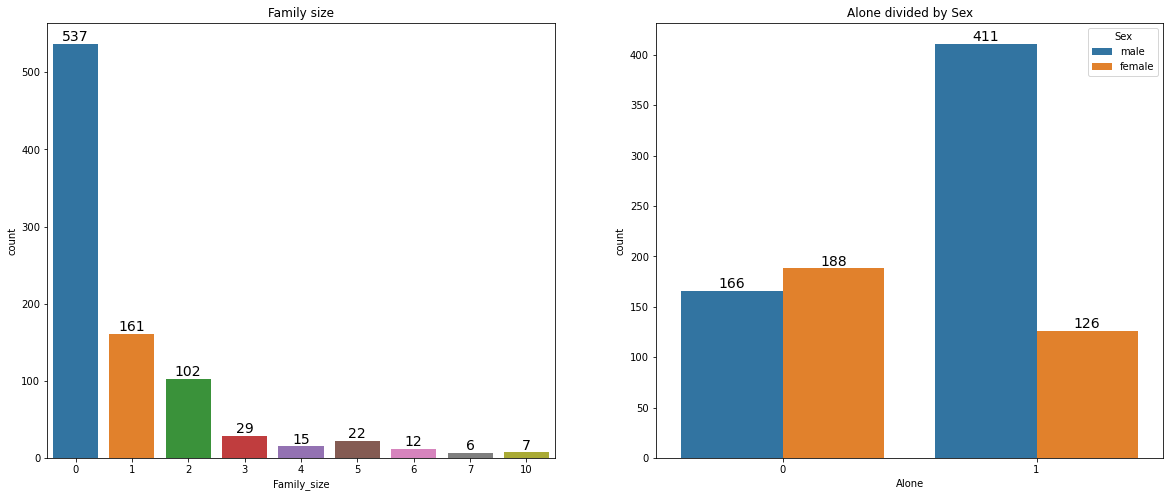

In [60]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2)

ax1 = axs[0]
ax = sns.countplot(x='Family_size', data=train, ax=ax1)
ax1.set_title('Family size')
ax.bar_label(ax.containers[0], fontsize=14);

ax2 = axs[1]
ax = sns.countplot(x='Alone', hue="Sex", data=train, ax=ax2)
ax2.set_title('Alone divided by Sex')
for container in ax2.containers:
    ax2.bar_label(container, fontsize=14);

plt.show()

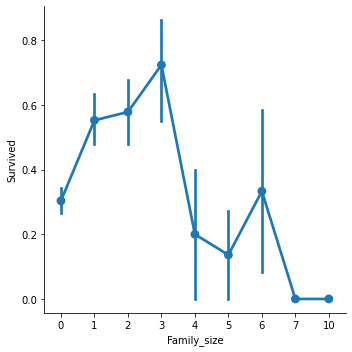

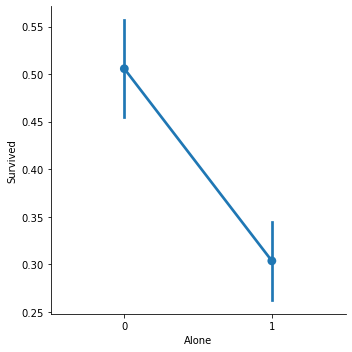

In [61]:
ax1 = sns.catplot(x='Family_size', y='Survived', data=train, kind='point')
ax2 = sns.catplot(x='Alone', y='Survived', data=train, kind='point')

plt.show()

**Conclusions to variables:**

If a person traveled alone, their chances of survival were minimal.\
The maximum family size was 10 people.\
The highest chances of survival were observed among families of three members.

### Convert Fare to Fare_band

**Why should we transform the Fare column:**

The situation with the fare prices is similar to that of Age. It is a continuous variable that we should transform into a categorical variable.

Let's divide our fare variable into 5 intervals using **pandas.qcut**.
**qcut** divides the values into 5 equal-sized bins.

In [62]:
pd.DataFrame(train.groupby(pd.qcut(train['Fare'],5))['Survived'].mean())

,Survived
Fare,
"(-0.001, 7.854]",0.217877
"(7.854, 10.5]",0.201087
"(10.5, 21.679]",0.424419
"(21.679, 39.688]",0.444444
"(39.688, 512.329]",0.642045


We have obtained 5 intervals along with their respective boundary values. With this information, we can divide the Fare variable into 5 groups, creating a new variable called **Fare_band**.

In [63]:
train['Fare_band'] = 0

In [64]:
train.loc[train['Fare'] <= 7.854,'Fare_band'] = 0
train.loc[(train['Fare'] > 7.854) & (train['Fare'] <= 10.5),'Fare_band'] = 1
train.loc[(train['Fare'] > 10.5) & (train['Fare'] <= 21.679),'Fare_band'] = 2
train.loc[(train['Fare'] > 21.679) & (train['Fare'] <= 39.688),'Fare_band'] = 3
train.loc[train['Fare'] > 39.688,'Fare_band'] = 4

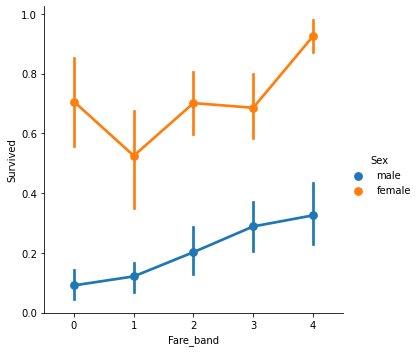

In [65]:
ax1 = sns.catplot(x='Fare_band', y='Survived', hue='Sex', data=train, kind='point')

plt.show()

**Conclusions to the variable:**

We can see that the higher the fare value, the greater the chances of survival, regardless of gender.\
This conclusion aligns with the information we obtained when analyzing Pclass.

### Pseudo Label Encoding

We know that the higher the class, the lower the value in our variable. However, machine learning models will interpret this inversely. Therefore, we should invert the values so that the highest value corresponds to the highest class.

In [66]:
train["Pclass"] = train["Pclass"].replace([1,2,3], [2,1,0])

### Dropping unnecessary variables

**PassengerId** &rarr; Cannot be categorised.

**Name** &rarr; We don't need name feature as it cannot be converted into any categorical value.

**Age** &rarr; We have the Age_band feature, so no need of this.

**Ticket** &rarr; It is any random string that cannot be categorised.

**Fare** &rarr; We have the Fare_band feature, so unneeded

**Cabin** &rarr; A lot of NaN values and also many passengers have multiple cabins. So this is a useless feature.



In [67]:
train.drop(['PassengerId','Name','Age','Ticket','Fare','Cabin'], axis=1, inplace=True)

In [68]:
train.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_size,Alone,Fare_band
0,0,0,male,1,0,S,Mr,1,1,0,0
1,1,2,female,1,0,C,Mrs,2,1,0,4
2,1,0,female,0,0,S,Miss,1,0,1,1
3,1,2,female,1,0,S,Mrs,2,1,0,4
4,0,0,male,0,0,S,Mr,2,0,1,1


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Survived     891 non-null    int64 
 1   Pclass       891 non-null    int64 
 2   Sex          891 non-null    object
 3   SibSp        891 non-null    int64 
 4   Parch        891 non-null    int64 
 5   Embarked     891 non-null    object
 6   Initial      891 non-null    object
 7   Age_band     891 non-null    int64 
 8   Family_size  891 non-null    int64 
 9   Alone        891 non-null    object
 10  Fare_band    891 non-null    int64 
dtypes: int64(7), object(4)
memory usage: 76.7+ KB


### Separate Survided and other variables

In [70]:
X = train.drop("Survived", axis=1).copy()
y = train[['Survived']]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Pclass       891 non-null    int64 
 1   Sex          891 non-null    object
 2   SibSp        891 non-null    int64 
 3   Parch        891 non-null    int64 
 4   Embarked     891 non-null    object
 5   Initial      891 non-null    object
 6   Age_band     891 non-null    int64 
 7   Family_size  891 non-null    int64 
 8   Alone        891 non-null    object
 9   Fare_band    891 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 69.7+ KB


### OneHotEncoder

OneHotEncoder is a method used in machine learning and data preprocessing to transform categorical features into a format that can be used for machine learning algorithms.\
This encoder converts categorical variables (which can take on one of a limited, fixed number of possible values) into a binary vector representation. This transformation is necessary because many machine learning algorithms cannot directly work with categorical data, which is typically in the form of text labels. Instead, these algorithms require numerical input.

In this case, we will create a custom transformer that allows us to transform our dataset.

In [71]:
## OHE transformer using get_dummies
class TransformerEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.get_dummies(X)
        return X

In [72]:
# Feature engineering
X_OHE = Pipeline([('OHE on non-numeric columns', TransformerEncoder())])

In [73]:
%%time

X_OHE.fit(X)
X_OHE_transform = X_OHE.transform(X)

CPU times: total: 0 ns
Wall time: 7.1 ms


In [74]:
X_OHE_transform

,Pclass,SibSp,Parch,Age_band,Family_size,Fare_band,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Initial_Master,Initial_Miss,Initial_Mr,Initial_Mrs,Initial_Other,Alone_0,Alone_1
0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,2,1,0,2,1,4,1,0,1,0,0,0,0,0,1,0,1,0
2,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1
3,2,1,0,2,1,4,1,0,0,0,1,0,0,0,1,0,1,0
4,0,0,0,2,0,1,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,0,1,0,2,0,1,0,0,1,0,0,0,0,1,0,1
887,2,0,0,1,0,3,1,0,0,0,1,0,1,0,0,0,0,1
888,0,1,2,1,3,3,1,0,0,0,1,0,1,0,0,0,1,0
889,2,0,0,1,0,3,0,1,1,0,0,0,0,1,0,0,0,1


In [75]:
X_OHE_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Pclass          891 non-null    int64
 1   SibSp           891 non-null    int64
 2   Parch           891 non-null    int64
 3   Age_band        891 non-null    int64
 4   Family_size     891 non-null    int64
 5   Fare_band       891 non-null    int64
 6   Sex_female      891 non-null    uint8
 7   Sex_male        891 non-null    uint8
 8   Embarked_C      891 non-null    uint8
 9   Embarked_Q      891 non-null    uint8
 10  Embarked_S      891 non-null    uint8
 11  Initial_Master  891 non-null    uint8
 12  Initial_Miss    891 non-null    uint8
 13  Initial_Mr      891 non-null    uint8
 14  Initial_Mrs     891 non-null    uint8
 15  Initial_Other   891 non-null    uint8
 16  Alone_0         891 non-null    uint8
 17  Alone_1         891 non-null    uint8
dtypes: int64(6), uint8(12)
memory 

In [76]:
X = X_OHE_transform.copy()

## Modeling

We have completed our variable analysis. We have our observations and conclusions on factors that may have influenced survival chances. However, we cannot definitively state or predict whether a given passenger survived the disaster.

To achieve this goal, we need to use machine learning models, which excel in such tasks.\
Initially, we will use popular algorithms:

1) Naive Bayes\
2) Logistic Regression\
3) Support Vector Machines\
4) Decision Tree\
5) Random Forest\
6) K-Nearest Neighbors

### Trening and test data

Let's split our dataset into training and testing sets.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)
print('X_train:', X_train.shape,'y_train:', y_train.shape)
print('X_test:', X_test.shape,'y_test:', y_test.shape)

X_train: (623, 18) y_train: (623, 1)
X_test: (268, 18) y_test: (268, 1)


### Model selection and evaluation functions

Let's define functions now to automate hyperparameter tuning and model evaluation.

In [78]:
# function for tuning hyperparams of a classifiers

def optimize_model(model, param_grid, cv = 5, X_train = X_train, y_train = y_train):
    '''Performs grid search over param_grid with cv-fold cross validation.
    
    Function arguments:
        model: sklearn classifier
        param_grid (dict): parameters grid
        cv (int): number of folds in cross validation
        X_train (array): training set
        y_train (array): training labels
        
    Returns:
        Best model found, fitted on the entire data set.
    '''
    
    optimizer = GridSearchCV(model, param_grid = param_grid, scoring="accuracy", cv = cv, n_jobs = -1, verbose = True)
    optimizer.fit(X_train, y_train)
    print('Best parameters found:')
    print(optimizer.best_params_)
    print('\nBest score: %0.6f' % (optimizer.best_score_))
    
    return optimizer.best_estimator_

In [79]:
# function to evalute tuned models on the test set

def evaluate_model(model, X_test = X_test, y_test = y_test):
    '''
    Function arguments:
        model: fitted sklearn classifier
        X_test (array): testing set
        y_test (array): testing labels
    '''
    
    y_pred = model.predict(X_test)
    print('\nClassification report: ')
    print(classification_report(y_test, y_pred))

### Baseline models

Before we start searching for the best model, let's examine two baseline models.

Let's begin by obtaining a baseline using GaussianNB and MultinomialNB. Since almost all features take on values of 0 or 1, MultinomialNB seems like a good idea.

#### GaussianNB

Gaussian Naive Bayes is a variant of the Naive Bayes classification algorithm. It is based on Bayes' theorem and assumes that the features follow a normal (Gaussian) distribution. It is particularly effective for high-dimensional data and is often used in text classification and other applications where the features are continuous and can be assumed to be normally distributed.

**Advantages**
1. Fast and Efficient: GaussianNB is computationally efficient and fast, making it suitable for large datasets.
2. Simple to Implement: The algorithm is straightforward to implement and requires minimal parameter tuning.
3. Works Well with High-Dimensional Data: It handles high-dimensional data well, as the independence assumption simplifies the computation.
4. Probabilistic Output: GaussianNB provides probabilistic outputs, which can be useful for certain applications such as risk assessment and decision making.
5. Robust to Irrelevant Features: The algorithm can handle irrelevant features well due to the independence assumption.

**Disadvantages**
1. Strong Assumptions: The assumption of normality and independence of features can be unrealistic in many real-world scenarios, potentially affecting performance.
2. Sensitivity to Outliers: GaussianNB can be sensitive to outliers, which can significantly affect the estimated parameters (mean and variance) of the Gaussian distribution.
3. Limited to Continuous Features: GaussianNB is specifically designed for continuous features that follow a normal distribution. For categorical features, other variants of Naive Bayes (e.g., MultinomialNB or BernoulliNB) may be more appropriate.
4. Not Suitable for Highly Correlated Features: The performance can degrade if the features are highly correlated, as the independence assumption is violated.

In [80]:
basemodel1 = GaussianNB()
basemodel1.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, basemodel1.predict(X_test)), 6))
evaluate_model(basemodel1)

Best score: 0.809701

Classification report: 
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       158
           1       0.77      0.76      0.77       110

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



In [81]:
print('Cross validation - GaussianNB:', np.round(cross_val_score(GaussianNB(), X, y, cv = 5).mean(), 6))

Cross validation - GaussianNB: 0.786743


Let's save the obtained model.

In [82]:
dump(basemodel1, 'models/base_gaussianNB.joblib');

#### MultinomialNB

Multinomial Naive Bayes is another variant of the Naive Bayes classification algorithm, suitable for classification tasks with discrete features (e.g., word counts in text classification). It models the likelihood of the features under each class using a multinomial distribution.

**Advantages**
1. Efficient for Text Classification: MultinomialNB is particularly effective for text classification tasks where features are typically word counts or term frequencies.
2. Simple and Fast: It is computationally efficient and fast to train, making it suitable for large datasets with many features.
3. Handles Sparse Data: It handles sparse data well, which is common in text classification when the feature space is large and many features are zero.
4. Handles Multiple Classes: MultinomialNB naturally supports multi-class classification problems.
5. Interpretable Outputs: It provides interpretable outputs in terms of class probabilities, which can be useful for decision-making.

**Disadvantages**
1. Strong Independence Assumption: The assumption of feature independence given the class can be unrealistic in practice, which may affect the model's performance.
2. Limited to Count Data: MultinomialNB is designed for features that are represented as counts or frequencies, limiting its applicability to other types of data.
3. Sensitive to Feature Scaling: It may not perform well if the features are not scaled appropriately, especially when dealing with continuous features that are not counts.
4. Sensitive to Outliers: Like other Naive Bayes models, MultinomialNB can be sensitive to outliers in the data.

In [83]:
basemodel2 = MultinomialNB()
basemodel2.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, basemodel2.predict(X_test)), 6))
evaluate_model(basemodel2)

Best score: 0.798507

Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       158
           1       0.75      0.75      0.75       110

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



In [84]:
print('Cross validation - MultinomialNB:', np.round(cross_val_score(MultinomialNB(), X, y, cv = 5).mean(), 6))

Cross validation - MultinomialNB: 0.797947


Let's save the obtained model.

In [85]:
dump(basemodel2, 'models/base_multinomialNB.joblib');

We achieved quite a decent result with minimal effort!

Both GaussianNB and MultinomialNB provided very similar results. Cross-validation of these basic models yielded an accuracy score of around 0.8.\
We observe that both models predict non-survivors more accurately than survivors.

Hopefully, more sophisticated classifiers will be able to predict survival with higher precision.

### Popular classifiers

Let's optimize some popular classifiers now and test their performance on our test dataset. First, we will conduct a grid search with "sparse" parameter sets.\
Later on, we will refine our search.

#### Logistic Regression

Logistic Regression is a statistical method used for binary classification problems, though it can be extended to multi-class problems through techniques like one-vs-rest and multinomial logistic regression. It is one of the most fundamental and widely used algorithms in machine learning.

**Advantages**
1. Interpretability: Logistic regression provides coefficients that can be interpreted as the impact of each feature on the probability of the target event. This makes it highly interpretable compared to more complex models.
2. Probability Estimates: Logistic regression outputs probabilities, providing a measure of confidence in the predictions.
3. Efficient and Scalable: It is computationally efficient and can handle large datasets and high-dimensional data.
4. Regularization: Logistic regression can be regularized using techniques like L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting.
5. Less Prone to Overfitting: Due to its simplicity, logistic regression is less prone to overfitting, especially when the number of features is not excessively large compared to the number of observations.

**Disadvantages**
1. Linear Decision Boundary: Logistic regression assumes a linear relationship between the features and the log-odds of the outcome. It may perform poorly if the actual relationship is not linear.
2. Feature Engineering: It often requires extensive feature engineering and may not capture complex relationships between features without proper transformations.
3. Limited to Binary Outcomes: While logistic regression can be extended to multi-class classification, it is naturally suited for binary outcomes, and its performance might not be optimal for multi-class problems without adaptation.
4. Sensitive to Outliers: Logistic regression can be sensitive to outliers, which can affect the estimation of model parameters.

In [86]:
# Create a pipeline
lr_model = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression())])

# Create a paramter grid
lr_param_grid = {'model__C' : 10**np.arange(-3,4, dtype = float), 
                 'model__penalty' : ['l1', 'l2', 'elasticnet'],  
                 'model__class_weight' : ['balanced', None]}

In [87]:
%%time

lr_baseline = LogisticRegression(random_state = 0)
lr_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, lr_baseline.predict(X_test)), 6))
evaluate_model(lr_baseline)

Best score: 0.83209

Classification report: 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       158
           1       0.82      0.76      0.79       110

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268

CPU times: total: 15.6 ms
Wall time: 37.9 ms


Let's optimize the hyperparameters and evaluate the model on the test set.

In [88]:
%%time

lr_model = optimize_model(lr_model, lr_param_grid)
evaluate_model(lr_model)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters found:
{'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2'}

Best score: 0.820142

Classification report: 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       158
           1       0.81      0.75      0.78       110

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268

CPU times: total: 562 ms
Wall time: 8.65 s


We see that the default logistic regression has the best performance.

##### Confusion Matrix for Logistic Regression

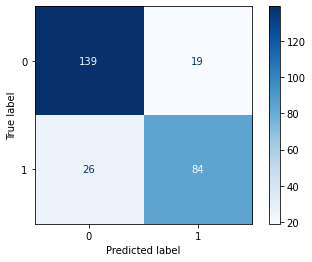

In [89]:
plot_confusion_matrix(lr_baseline, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We see that optimizing the parameter C did not improve the accuracy of the logistic regression model.

Let's select the best logistic regression model obtained.

In [90]:
dump(lr_baseline, 'models/lr_baseline.joblib');

#### SVM

Support Vector Machine (SVM) is a powerful supervised machine learning algorithm used for both classification and regression tasks. It is particularly well-known for its effectiveness in high-dimensional spaces and for its robustness in handling linear and non-linear data.

**Advantages**
1. Effective in High-Dimensional Spaces: SVM is very effective in high-dimensional spaces and is suitable for datasets where the number of dimensions is greater than the number of samples.
2. Memory Efficiency: It is relatively memory efficient because it uses a subset of training points (support vectors) in the decision function.
3. Versatility with Kernel Trick: The use of different kernel functions allows SVM to handle various types of relationships within data, making it a versatile algorithm.
4. Robustness to Overfitting: SVMs are robust to overfitting, especially in high-dimensional spaces, given the appropriate choice of kernel and regularization parameters.

**Disadvantages**
1. Computationally Intensive: Training an SVM can be computationally intensive and time-consuming, especially with large datasets.
2. Sensitivity to Parameter Selection: The performance of SVM is highly dependent on the choice of parameters (such as the regularization parameter C and the kernel parameters).
3. Not Suitable for Large Datasets: SVMs can be less efficient for very large datasets due to their high computational complexity.
4. Difficult Interpretation: The resulting model from SVM, especially when using non-linear kernels, can be difficult to interpret.

In [91]:
# Create a pipeline
svm_model = Pipeline([("scaler", StandardScaler()), ("model", SVC())])

# Create a parameter grid
svm_param_grid = {'model__C' : 10**np.arange(-4,5, dtype = float),
                  'model__gamma' : [10**np.arange(-5,2, dtype = float), 'scale', 'auto'],
                  'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
                 }

First, let's check the performance of basic Support Vector Machines.

In [92]:
%%time

svm_baseline = SVC(random_state = 0)
svm_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, svm_baseline.predict(X_test)), 6))
evaluate_model(svm_baseline)

Best score: 0.828358

Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       158
           1       0.83      0.73      0.78       110

    accuracy                           0.83       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268

CPU times: total: 31.2 ms
Wall time: 55.1 ms


Let's optimize the hyperparameters and evaluate the model on the test set.

In [93]:
%%time

svm_model = optimize_model(svm_model, svm_param_grid)
evaluate_model(svm_model)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters found:
{'model__C': 1.0, 'model__gamma': 'scale', 'model__kernel': 'poly'}

Best score: 0.821794

Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       158
           1       0.84      0.74      0.79       110

    accuracy                           0.84       268
   macro avg       0.84      0.82      0.83       268
weighted avg       0.84      0.84      0.83       268

CPU times: total: 969 ms
Wall time: 13min 18s


##### Confusion Matrix for SVM

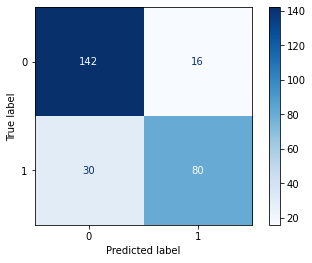

In [94]:
plot_confusion_matrix(svm_baseline, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

The best result was achieved by the basic SVM. Searching for the best parameters slightly worsened the result.

Let's save the basic SVM model.

In [95]:
dump(svm_baseline, 'models/svm_baseline.joblib');

#### Decision Tree Classifier

This crassifier is a machine learning algorithm used to solve classification problems. It models decisions in the form of a tree, where each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf represents a class label.

**Advantages**

1. Intuitiveness and Simplicity: Decision trees are easy to understand and interpret. The resulting model is represented in the form of a tree, allowing for a clear presentation of decisions. Visualizing the tree can help in understanding the model's behavior, which is beneficial for model explainability (interpretability).
2. Minimal Data Preparation: Decision trees require minimal data preparation. They do not need data normalization or scaling.
3. Handling Categorical and Continuous Data: Decision trees can work with both categorical and continuous data.

4. No Need for Complex Relationships Between Variables: Decision trees can capture non-linear relationships between variables.

**Disadvantages**

1. Tendency to Overfit: Decision trees tend to overfit, especially when they are very deep and have many nodes. This can lead to very complex models that fit noise in the training data.
2. Sensitivity to Data Changes: Decision trees can be sensitive to changes in data. Small changes in the training data can lead to a completely different tree.
3. Relatively Low Performance: Standalone decision trees often have lower predictive performance compared to more advanced techniques like Random Forest or Gradient Boosting.

In [96]:
# create a pipeline
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier())])

# create parameter grids
tree_param_grid = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [2, 5, 10, 20, 30],
                   'model__min_samples_leaf': [5, 10, 20, 30]}

First, let's check the performance of the base Decision Tree Classifier.

In [97]:
%%time

tree_baseline = DecisionTreeClassifier(random_state = 0)
tree_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, tree_baseline.predict(X_test)), 6))
evaluate_model(tree_baseline)

Best score: 0.798507

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       158
           1       0.80      0.67      0.73       110

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.80      0.79       268

CPU times: total: 0 ns
Wall time: 15.4 ms


Let's optimize the hyperparameters and evaluate the model on the test set.

In [99]:
%%time

tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:
{'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_leaf': 5}

Best score: 0.829884

Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       158
           1       0.83      0.71      0.76       110

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

CPU times: total: 453 ms
Wall time: 6.05 s


The min_samples_leaf parameter has a threshold value, let's expand our search. Let's set the other parameters as we received from the previous model.

In [100]:
%%time

tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier(criterion = 'entropy'))])
tree_param_grid = {'model__min_samples_leaf': np.arange(1,11),
                   'model__max_depth': np.arange(15,26,1)}
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best parameters found:
{'model__max_depth': 18, 'model__min_samples_leaf': 4}

Best score: 0.834684

Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       158
           1       0.87      0.70      0.77       110

    accuracy                           0.83       268
   macro avg       0.84      0.81      0.82       268
weighted avg       0.84      0.83      0.83       268

CPU times: total: 938 ms
Wall time: 1.81 s


##### Confusion Matrix for Decision Tree Classifier

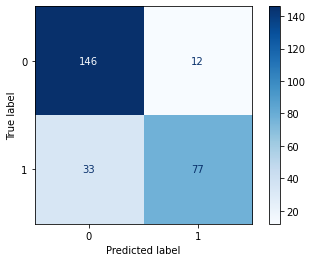

In [101]:
plot_confusion_matrix(tree_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We have concluded our search. Our best decision tree includes criteria such as entropy, a maximum depth of 15, and a minimum number of samples in a leaf node set to 4.

Let's select the best decision tree classifier model obtained.

In [102]:
dump(tree_model, 'models/tree_model.joblib');

#### Random Forest Classifier

Random Forest is an ensemble learning method that combines multiple decision trees to improve generalizability and robustness over a single decision tree classifier. 

**Advantages**
1. High Accuracy: Random Forest generally achieves higher accuracy compared to single decision trees by reducing variance and overfitting.
2. Versatility: It can handle both classification and regression tasks effectively.
3. Feature Importance: Provides a feature importance ranking, which can be useful for feature selection and understanding the dataset.
4. Robustness: Robust to outliers in the data and works well with non-linear relationships.
5. Handles High-Dimensional Data: Can handle datasets with a large number of features and instances.

**Disadvantages**
1. Complexity: Random Forests are less interpretable than individual decision trees. They provide less insight into the relationships between features and the target variable.
2. Computationally Expensive: Training multiple decision trees and combining them can be computationally expensive, especially for large datasets.
3. Memory Consumption: Requires more memory and storage to store multiple trees compared to simpler models.
4. Not Suitable for Very Sparse Data: Random Forest may not perform well on very sparse datasets, where features have very low occurrences.

In [103]:
# create a pipeline
forest_model = Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier())])

# create parameter grids
forest_param_grid = {'model__n_estimators': [200, 500, 1000],
                     'model__max_depth' : [5, 15, 50],
                     'model__min_samples_leaf': [5, 10, 20],
                     'model__criterion': ['gini', 'entropy']}

First, let's check the performance of the base Random Forest Classifier.

In [104]:
%%time

forest_baseline = RandomForestClassifier(random_state = 0)
forest_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, forest_baseline.predict(X_test)), 6))
evaluate_model(forest_baseline)

Best score: 0.813433

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       158
           1       0.82      0.70      0.75       110

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

CPU times: total: 141 ms
Wall time: 189 ms


Let's optimize the hyperparameters and evaluate the model on the test set.

In [105]:
%%time

forest_model = optimize_model(forest_model, forest_param_grid)
evaluate_model(forest_model)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found:
{'model__criterion': 'entropy', 'model__max_depth': 15, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}

Best score: 0.837871

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       158
           1       0.86      0.68      0.76       110

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 1.42 s
Wall time: 1min 39s


Let's find better values for the parameters that have a threshold. Let's set the criterion parameters as we received from the previous model.

In [131]:
%%time

forest_model = Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier(criterion = 'entropy'))])
forest_param_grid = {'model__n_estimators': np.arange(100, 750, 50),
                     'model__max_depth' : np.arange(10, 26, 3),
                     'model__min_samples_leaf': np.arange(1, 10, 1)}
forest_model = optimize_model(forest_model, forest_param_grid)
evaluate_model(forest_model)

Fitting 5 folds for each of 702 candidates, totalling 3510 fits
Best parameters found:
{'model__max_depth': 13, 'model__min_samples_leaf': 2, 'model__n_estimators': 450}

Best score: 0.847548

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       158
           1       0.86      0.68      0.76       110

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 16.7 s
Wall time: 16min 5s


It looks like we've found the region where the best parameters are located. Let's narrow down this region.

In [133]:
%%time

forest_model = Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier(min_samples_leaf = 2,
                                                                                        criterion = 'entropy'))])
forest_param_grid = {'model__n_estimators': np.arange(440, 510, 5),
                     'model__max_depth' : np.arange(9, 17, 1)}
forest_model = optimize_model(forest_model, forest_param_grid)
evaluate_model(forest_model)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best parameters found:
{'model__max_depth': 15, 'model__n_estimators': 445}

Best score: 0.847548

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       158
           1       0.85      0.68      0.76       110

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

CPU times: total: 3.06 s
Wall time: 3min 19s


##### Confusion Matrix for Random Forest Classifier

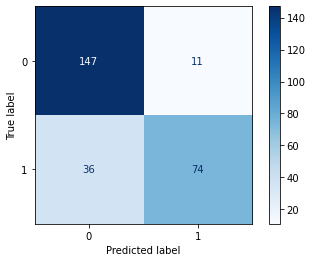

In [108]:
plot_confusion_matrix(forest_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We have completed our search. Our best random forest model includes criteria such as entropy, maximum depth of 15, minimum number of samples in a leaf node of 2, and 445 estimators.

Let's save the best Random Forest Classifier model.

In [134]:
dump(forest_model, 'models/forest_model.joblib');

#### KNeighborsClassifier

K-Nearest Neighbors (KNN) is a simple and intuitive classification algorithm that works based on the similarity of data points. 

**Advantages**
1. Simple and Intuitive: KNN is easy to understand and implement, making it a good starting point for classification problems.
2. No Training Phase: There is no explicit training phase in KNN. The model simply memorizes the training data, making it fast to train.
3. Versatile: KNN can be applied to both classification and regression tasks.
4. Non-Linear Decision Boundaries: KNN can capture non-linear decision boundaries, depending on the chosen distance metric and value of k.

**Disadvantages**
1. Computational Complexity: Making predictions with KNN can be computationally expensive, especially for large datasets and high-dimensional feature spaces. It requires calculating distances from the query point to all training samples.
2. Memory Usage: KNN stores all the training data, which can be memory-intensive for large datasets.
3. Sensitive to Noise and Outliers: Outliers and noisy data can significantly impact the performance of KNN, as they can distort distance calculations and affect predictions.
4. Need for Optimal k: Choosing the optimal value of k is crucial and may require experimentation and validation to achieve good performance.

In [110]:
# create a pipeline
knn_model = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsClassifier())])

# create parameter grids
knn_param_grid = {'model__n_neighbors': np.arange(1,16,1),
                  'model__weights' : ['uniform', 'distance']
                 }

First, let's check the performance of the base KNeighbors classifier.

In [111]:
%%time

knn_baseline = KNeighborsClassifier()
knn_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, knn_baseline.predict(X_test)), 6))
evaluate_model(knn_baseline)

Best score: 0.783582

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       158
           1       0.75      0.70      0.73       110

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268

CPU times: total: 125 ms
Wall time: 66.4 ms


Let's optimize the hyperparameters and evaluate the model on the test set.

In [112]:
%%time

knn_model = optimize_model(knn_model, knn_param_grid)
evaluate_model(knn_model)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:
{'model__n_neighbors': 10, 'model__weights': 'uniform'}

Best score: 0.826658

Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       158
           1       0.90      0.64      0.74       110

    accuracy                           0.82       268
   macro avg       0.84      0.79      0.80       268
weighted avg       0.83      0.82      0.81       268

CPU times: total: 1.25 s
Wall time: 2.84 s


##### Confusion Matrix for KNeighborsClassifier

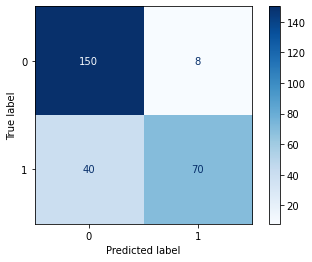

In [113]:
plot_confusion_matrix(knn_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We have completed our search. Our best KNeighbors model uses uniform weights and has n_neighbors set to 12.

Let's select the best KNeighbors classifier model obtained.

In [114]:
dump(knn_model, 'models/knn_model.joblib');

## Ensembling

Ensembling is a machine learning technique that involves combining multiple models (often referred to as base models or weak learners) to improve the overall performance of a predictive model. Here are the key characteristics of ensembling:

**Types of Ensembling**
- **Bagging (Bootstrap Aggregating)**:\
     Involves training multiple instances of the same base model on different subsets of the training data (sampled with replacement). Predictions are aggregated (e.g., averaged for regression, majority vote for classification).

- **Boosting**:\
     Builds an ensemble model iteratively by sequentially training new models that focus on instances that previous models have misclassified. Examples include AdaBoost, Gradient Boosting Machines (GBM), and XGBoost.

- **Stacking or Voting**:\
     StackingClassifier and VotingClassifier are two different methods of combining multiple models (ensembling) to improve classifier performance.     
     - **VotingClassifier** combines the predictions of multiple models using a voting method. There are two main types of voting:
        - Hard Voting: Each model makes a classification, and the final classification is chosen based on the majority vote. This means that the class with the most votes is selected as the final predicted class.
        - Soft Voting: Each model predicts the probability for each class, and the final predicted class is chosen based on the averaged probabilities. This is more advanced than hard voting because it takes into account the confidence of the models' predictions.
     - **StackingClassifier** combines the predictions of multiple models using a meta-learner. In stacking, the predictions (or outputs) of the base models are used as features to train the meta-learner. The meta-learner (final estimator) learns from these predictions to make the final classification.

**Advantages**
- **Improved Accuracy**:\
     Ensembling often results in better prediction accuracy compared to individual models, especially when models are diverse and complementary.

- **Robustness**:\
     Ensembles are generally more robust to overfitting and noise in the data, as errors tend to cancel out or diminish when models are combined.

- **Versatility**:\
     Ensembling can be applied to various machine learning algorithms and tasks, including classification, regression, and anomaly detection.

**Challenges**
- **Complexity**:\
     Ensembling adds complexity to the model, requiring more computational resources and potentially longer training times.

- **Interpretability**:\
     Interpretability of ensemble models can be challenging, especially when using complex combinations of models.

- **Overfitting**:\
     While ensembling can reduce overfitting, it is still possible to overfit if base models are not properly trained or if the ensemble is overly complex.

### Bagging

Bagging stands for Bootstrap Aggregating. It's a machine learning ensemble technique where multiple models are trained independently on different subsets of the training data using bootstrapping (sampling with replacement). Here’s how it works:

1. Bootstrap Sampling: Multiple subsets of the training data are created by random sampling with replacement.
2. Model Training: A base model (like Decision Trees, KNN, etc.) is trained independently on each subset of data
3. Prediction: When making predictions, each model predicts independently, and the final prediction is often determined by aggregating (e.g., averaging for regression or voting for classification) the predictions from all models.

#### Bagged KNN

The workflow of Bagged K-Nearest Neighbors (KNN) follows a similar process to the Bagged Decision Tree, but it applies the bootstrap aggregating (bagging) technique to the KNN algorithm. Here is a step-by-step guide to the workflow:

**Workflow of Bagged K-Nearest Neighbors (KNN):**
1. Bootstrap Sampling:
- Create multiple bootstrap samples from the original training dataset by randomly sampling with replacement. Each bootstrap sample will have the same number of instances as the original dataset but with some instances repeated and some omitted.
2. Train KNN Models:
- Train a separate KNN model on each bootstrap sample independently. Each KNN model will be fitted to its respective bootstrap sample.
3. Make Predictions:
- For a new data point (instance) that needs to be classified or predicted, each trained KNN model will make its prediction independently.
4. Aggregate Predictions:
- For classification tasks: Use majority voting to combine the predictions of all the KNN models. The final predicted class is the one that receives the most votes from the individual KNN models.
- For regression tasks: Average the predictions of all the KNN models to obtain the final predicted value.

**Advantages**:
- Reduced Overfitting: Bagging reduces the variance of the model by averaging multiple KNN models, which helps to mitigate overfitting.
- Improved Stability: The ensemble of KNN models is more stable and less sensitive to variations in the training data compared to a single KNN model.
- Enhanced Performance: Bagging often improves the overall accuracy and generalization ability of the KNN algorithm.

**Disadvantages**:
- Computational Cost: Training multiple KNN models on different bootstrap samples can be computationally intensive and requires more memory.
- Increased Prediction Time: Making predictions with an ensemble of KNN models is slower compared to a single KNN model due to the aggregation step.

In [119]:
# create a pipeline
bagging_knn_model = Pipeline([("model", BaggingClassifier(KNeighborsClassifier(n_neighbors = 10, weights = 'uniform'), random_state=0))])

# create parameter grids
bagging_knn_param_grid = {'model__n_estimators' : np.arange(100, 700, 100)}

In [120]:
%%time

bagging_knn_model = optimize_model(bagging_knn_model, bagging_knn_param_grid)
evaluate_model(bagging_knn_model)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found:
{'model__n_estimators': 100}

Best score: 0.817045

Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       158
           1       0.85      0.63      0.72       110

    accuracy                           0.80       268
   macro avg       0.82      0.78      0.78       268
weighted avg       0.81      0.80      0.80       268

CPU times: total: 1.72 s
Wall time: 9.4 s


Let's optimize the hyperparameters and evaluate the model on the test set.

In [121]:
%%time

# create a pipeline
bagging_knn_model = Pipeline([("model", BaggingClassifier(KNeighborsClassifier(n_neighbors = 10, weights = 'uniform'), random_state=0))])

# create parameter grids
bagging_knn_param_grid = {'model__n_estimators' : np.arange(10, 150, 1)}
bagging_knn_model = optimize_model(bagging_knn_model, bagging_knn_param_grid)
evaluate_model(bagging_knn_model)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best parameters found:
{'model__n_estimators': 72}

Best score: 0.817058

Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       158
           1       0.85      0.63      0.72       110

    accuracy                           0.80       268
   macro avg       0.82      0.78      0.78       268
weighted avg       0.81      0.80      0.80       268

CPU times: total: 4.16 s
Wall time: 1min


##### Confusion Matrix for Bagged KNN

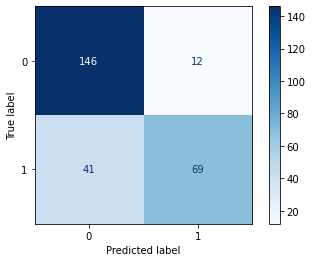

In [122]:
plot_confusion_matrix(bagging_knn_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We have found the best parameters for the model. Let's save the best Bagging KNN model obtained.

In [123]:
dump(bagging_knn_model, 'models/bagging_knn_model.joblib');

#### Bagged DecisionTree

**Workflow of Bagged Decision Tree**:

1. Bootstrap Sampling:
   - Create multiple bootstrap samples (subsets) from the original training dataset by sampling with replacement.
2. Train Decision Trees:
   - Train a separate decision tree on each bootstrap sample independently.
3. Aggregate Predictions:
   - For classification: Use majority voting to combine the predictions of all the decision trees.
   - For regression: Average the predictions of all the decision trees.

**Advantages**:
- Reduced Overfitting: Bagging helps to mitigate the overfitting problem commonly associated with decision trees by averaging multiple models.
- Improved Stability: The method stabilizes the model predictions, making them less sensitive to the fluctuations in the training data.
- Scalability: Parallel training of multiple decision trees allows bagging to scale efficiently with large datasets.

**Disadvantages**:
- Computational Cost: Training multiple decision trees can be computationally expensive and require more memory.
- Interpretability: The final model, being an ensemble of many decision trees, is less interpretable than a single decision tree.

In [124]:
# create a pipeline
bagging_DT_model = Pipeline([("model", BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', max_depth = 16, min_samples_leaf = 4), random_state=0))])

# create parameter grids
bagging_DT_param_grid = {'model__n_estimators' : np.arange(100, 1200, 200)}

In [125]:
%%time

bagging_DT_model = optimize_model(bagging_DT_model, bagging_DT_param_grid)
evaluate_model(bagging_DT_model)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found:
{'model__n_estimators': 500}

Best score: 0.839523

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       158
           1       0.86      0.68      0.76       110

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 1.34 s
Wall time: 17.5 s


It looks like we've found the region where the best parameters are located. Let's narrow down this region.

In [126]:
%%time

# create a pipeline
bagging_DT_model = Pipeline([("model", BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', max_depth = 16, min_samples_leaf = 4), random_state=0))])

# create parameter grids
bagging_DT_param_grid = {'model__n_estimators' : np.arange(350, 660, 50)}
bagging_DT_model = optimize_model(bagging_DT_model, bagging_DT_param_grid)
evaluate_model(bagging_DT_model)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters found:
{'model__n_estimators': 400}

Best score: 0.839523

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       158
           1       0.86      0.68      0.76       110

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 828 ms
Wall time: 13.7 s


We're getting closer. Let's keep searching.

In [127]:
%%time

# create a pipeline
bagging_DT_model = Pipeline([("model", BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', max_depth = 16, min_samples_leaf = 4), random_state=0))])

# create parameter grids
bagging_DT_param_grid = {'model__n_estimators' : np.arange(350, 460, 1)}
bagging_DT_model = optimize_model(bagging_DT_model, bagging_DT_param_grid)
evaluate_model(bagging_DT_model)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best parameters found:
{'model__n_estimators': 385}

Best score: 0.839523

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       158
           1       0.86      0.68      0.76       110

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 2.75 s
Wall time: 2min 33s


##### Confusion Matrix for Bagged DecisionTree

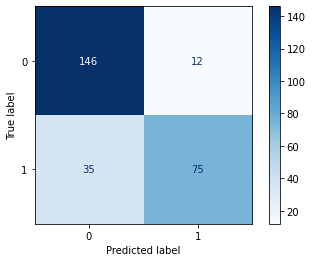

In [128]:
plot_confusion_matrix(bagging_DT_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We have found the best parameters for the model. Let's save the best Bagging DecisionTree model obtained.

In [129]:
dump(bagging_DT_model, 'models/bagging_DT_model.joblib');

### Boosting

Boosting is an ensemble technique that uses sequential learning of classifiers. It is a step-by-step improvement of a weak model. Boosting works as follows:

1. The model is first trained on the complete dataset. Initially, the model gets some predictions right and some wrong.
2. In the next iteration, the model focuses more on the incorrectly predicted instances or assigns them greater weight.
3. The model tries to correctly predict these misclassified instances.
4. This iterative process continues, and new classifiers are added to the model until a specified accuracy limit is reached.

#### AdaBoost(Adaptive Boosting)

AdaBoost (Adaptive Boosting) Classifier is a popular ensemble learning technique that aims to improve the performance of weak classifiers by combining them into a strong classifier. Here are its key characteristics:

1. Ensemble Learning: AdaBoost is an ensemble method, meaning it combines multiple weak learners to create a strong learner.
The weak learners are typically decision trees with a single split, known as decision stumps.
2. Adaptive Process: AdaBoost adjusts the weights of incorrectly classified instances so that subsequent weak learners focus more on these hard-to-classify cases.
Initially, all data points are assigned equal weights. In each iteration, weights are updated based on the performance of the current weak learner.
3. Sequential Learning: The classifiers are trained sequentially, with each new classifier trying to correct the errors of the previous one.
Each iteration of AdaBoost aims to reduce the overall classification error by emphasizing the misclassified instances.
4. Weighted Votes: Each weak learner contributes to the final model based on its accuracy. More accurate learners are given higher weight.
The final prediction is made by a weighted majority vote of the weak learners.
5. Robust to Overfitting: AdaBoost can be less prone to overfitting compared to other ensemble methods like bagging, especially when used with simple base learners.
6. Versatility: AdaBoost can be used for both classification and regression problems.
It can be combined with any machine learning algorithm, but decision stumps are commonly used.
7. Sensitivity to Noisy Data: AdaBoost can be sensitive to noisy data and outliers because it will continue to focus on hard-to-classify cases, which might be noise.

In [135]:
# create a pipeline
ada_model = Pipeline([("scaler", StandardScaler()),("model", AdaBoostClassifier(random_state=0))])

# create parameter grids
ada_param_grid = {'model__base_estimator' : [DecisionTreeClassifier(), RandomForestClassifier()],
                  'model__n_estimators' : np.arange(100, 1200, 200),
                  'model__learning_rate' : [0.05, 0.1, 0.2, 0.5]}

First, let's check the performance of the base AdaBoost classifier.

In [136]:
%%time

ada_model = optimize_model(ada_model, ada_param_grid)
evaluate_model(ada_model)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:
{'model__base_estimator': RandomForestClassifier(), 'model__learning_rate': 0.05, 'model__n_estimators': 300}

Best score: 0.805742

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       158
           1       0.83      0.70      0.76       110

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.81       268

CPU times: total: 50.4 s
Wall time: 1h 33min 43s


Let's optimize the hyperparameters and evaluate the model on the test set.

In [137]:
%%time

# create a pipeline
ada_model = Pipeline([("scaler", StandardScaler()),("model", AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.05, random_state=0))])

# create parameter grids
ada_param_grid = {'model__n_estimators' : np.arange(150, 460, 10)}
ada_model = optimize_model(ada_model, ada_param_grid)
evaluate_model(ada_model)

Fitting 5 folds for each of 31 candidates, totalling 155 fits
Best parameters found:
{'model__n_estimators': 240}

Best score: 0.808968

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       158
           1       0.83      0.70      0.76       110

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.81       268

CPU times: total: 36.2 s
Wall time: 55min 34s


##### Confusion Matrix for AdaBoost Classifier

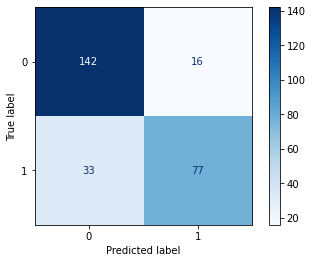

In [138]:
plot_confusion_matrix(ada_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We have found the best parameters for the model.

Let's save the best AdaBoost model obtained.

In [139]:
dump(ada_model, 'models/ada_model.joblib');

#### XGBoost

The XGBClassifier is an implementation of the Gradient Boosting framework by the XGBoost library specifically designed for classification problems. Here are some key characteristics:

1. Gradient Boosting Algorithm: XGBClassifier is based on the gradient boosting algorithm, which builds an ensemble of trees sequentially. Each new tree corrects the errors of the previously built trees.
2. Regularization: It includes L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting and improve the generalization of the model.
3. Handling Missing Values: XGBClassifier has built-in methods to handle missing values, making it robust to incomplete datasets.
4. Parallel Processing: It supports parallel processing, which speeds up training by utilizing multiple cores of a CPU.
5. Tree Pruning: The model uses a technique called “max_depth” to prune trees and avoid overfitting.
6. Cross-Validation: XGBoost offers built-in cross-validation to help find the best parameters for the model.
7. Feature Importance: It provides tools to visualize the importance of features, helping to understand which features are contributing the most to the predictions.
8. Scalability: XGBoost is highly scalable and can be used for very large datasets and in distributed computing environments.
9. Custom Objective and Evaluation Functions: Users can define their own objective and evaluation functions, giving them the flexibility to customize the model to their specific needs.

In [140]:
# create a pipeline
xgb_model = Pipeline([("scaler", StandardScaler()), ("model", xgb.XGBClassifier(eval_metric='error', random_state = 0))])

# create parameter grids
xgb_param_grid  = {'model__n_estimators': [200, 400, 800],
                   'model__max_depth': [5, 10, 20],
                   'model__learning_rate': [0.05, 0.1, 0.2],
                   'model__min_child_weight': [1, 10, 100]}

First, let's check the performance of the base XGBoost classifier.

In [141]:
%%time

xgb_baseline = xgb.XGBClassifier(eval_metric='error', random_state = 0)
xgb_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, xgb_baseline.predict(X_test)), 6))
evaluate_model(xgb_baseline)

Best score: 0.835821

Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       158
           1       0.87      0.71      0.78       110

    accuracy                           0.84       268
   macro avg       0.84      0.82      0.82       268
weighted avg       0.84      0.84      0.83       268

CPU times: total: 984 ms
Wall time: 273 ms


Let's optimize the hyperparameters and evaluate the model on the test set.

In [142]:
%%time

xgb_model = optimize_model(xgb_model, xgb_param_grid)
evaluate_model(xgb_model)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:
{'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 200}

Best score: 0.823445

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       158
           1       0.86      0.70      0.77       110

    accuracy                           0.83       268
   macro avg       0.84      0.81      0.82       268
weighted avg       0.83      0.83      0.82       268

CPU times: total: 4.56 s
Wall time: 1min 1s


All the parameters we are looking for have threshold values. Let's begin our search.

In [143]:
%%time

xgb_model = Pipeline([("scaler", StandardScaler()), ("model", xgb.XGBClassifier(eval_metric='error', 
                                                                                learning_rate = 0.05, 
                                                                                random_state = 0))])
xgb_param_grid  = {'model__n_estimators': np.arange(100, 310, 50),
                   'model__max_depth': np.arange(3, 9, 1),
                   'model__min_child_weight': np.arange(1, 11, 1)}
xgb_model = optimize_model(xgb_model, xgb_param_grid)
evaluate_model(xgb_model)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters found:
{'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 100}

Best score: 0.841110

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       158
           1       0.88      0.66      0.76       110

    accuracy                           0.82       268
   macro avg       0.84      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 8.42 s
Wall time: 1min 39s


It looks like we've found the region where the best parameters are located. Let's narrow down this region.

In [144]:
%%time

xgb_model = Pipeline([("scaler", StandardScaler()), ("model", xgb.XGBClassifier(eval_metric = 'error', 
                                                                                learning_rate = 0.05,
                                                                                max_depth = 3,
                                                                                min_child_weight = 3, 
                                                                                random_state = 0))])
xgb_param_grid  = {'model__n_estimators': np.arange(50, 150, 1)}
xgb_model = optimize_model(xgb_model, xgb_param_grid)
evaluate_model(xgb_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:
{'model__n_estimators': 93}

Best score: 0.842723

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       158
           1       0.88      0.66      0.76       110

    accuracy                           0.82       268
   macro avg       0.84      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 4.02 s
Wall time: 19.1 s


##### Confusion Matrix for XGB Classifier

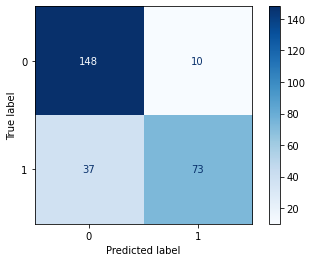

In [145]:
plot_confusion_matrix(xgb_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

We have found the best parameters for the model.

Let's save the best XGBoost model obtained.

In [146]:
dump(xgb_model, 'models/xgb_model.joblib');

### Stacking Classifier

A Stacking Classifier is an ensemble machine learning model that combines multiple individual models (base learners) and a meta-learner to improve prediction performance. Here are some key characteristics:

1. Combination of Models: It integrates predictions from various base models (such as decision trees, logistic regression, and support vector machines) using a meta-learner.
2. Meta-Learner: The meta-learner is a model trained on the predictions of the base models. It learns to correct the errors of the base models and make the final prediction.
3. Training Process:
- First Stage: Train each base model on the training dataset.
- Second Stage: Use the predictions of the base models as features to train the meta-learner.
4. Improved Performance: By leveraging the strengths of multiple models, stacking can enhance prediction accuracy and robustness compared to individual models.
5. Flexibility: Stacking allows the combination of different types of models and is flexible in terms of choosing both base learners and the meta-learner.
6. Implementation: It can be implemented using libraries such as scikit-learn in Python, with the StackingClassifier class.

In [147]:
stacking_final_estimator = LogisticRegression()

stacking_estimator_models = [('SVM', SVC(random_state = 0)),
                             ('DT', DecisionTreeClassifier(criterion = 'entropy',
                                                           max_depth = 18,
                                                           min_samples_leaf = 4,
                                                           random_state = 0
                                                          )),
                             ('RF', RandomForestClassifier(min_samples_leaf = 3,
                                                           criterion = 'entropy',
                                                           max_depth = 13,
                                                           n_estimators = 670,
                                                           random_state = 0
                                                          )),
                             ('KNN', KNeighborsClassifier(n_neighbors = 10,
                                                          weights = 'uniform'
                                                         )),
                             ('Bagging_DT', BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', 
                                                                                      max_depth = 15, 
                                                                                      min_samples_leaf = 4),
                                                              n_estimators = 385,
                                                              random_state=0)),
                             ('XGBoost', xgb.XGBClassifier(eval_metric = 'error', 
                                                           learning_rate = 0.05,
                                                           max_depth = 3,
                                                           min_child_weight = 3,
                                                           n_estimators = 93,
                                                           random_state = 0))
                            ]

# Create a pipeline
stacking_model = Pipeline([("scaler", StandardScaler()), ("model", StackingClassifier(stacking_estimator_models, final_estimator=stacking_final_estimator))])

# Create a paramter grid
stacking_param_grid = {}

In [148]:
%%time

stacking_model = optimize_model(stacking_model, stacking_param_grid)
evaluate_model(stacking_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}

Best score: 0.834632

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       158
           1       0.87      0.67      0.76       110

    accuracy                           0.82       268
   macro avg       0.84      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268

CPU times: total: 19.5 s
Wall time: 30.6 s


#### Confusion Matrix for Stacking Classifier

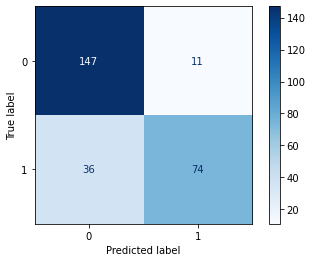

In [149]:
plot_confusion_matrix(stacking_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [150]:
dump(stacking_model, 'models/stacking_model.joblib');

### Voting Classifier

A Voting Classifier is an ensemble machine learning model that combines the predictions of multiple individual models (classifiers) to improve overall performance. Here are some key characteristics:

1. Combination of Models: It combines predictions from different types of models such as decision trees, logistic regression, and support vector machines.
2. Voting Mechanism: It uses a voting mechanism to make the final prediction. There are two main types of voting: hard and soft Voting.
3. Improved Performance: By combining multiple models, it often improves the accuracy and robustness of the predictions compared to individual models.
4. Flexibility: It allows for the combination of different types of models, which can be particularly useful when models have complementary strengths and weaknesses.
5. Implementation: It can be easily implemented using libraries such as scikit-learn in Python.

In [156]:
voting_model = VotingClassifier(estimators=[('LR', LogisticRegression()),
                                              ('SVM', SVC(random_state = 0)),
                                              ('DT', DecisionTreeClassifier(criterion = 'entropy',
                                                                            max_depth = 18,
                                                                            min_samples_leaf = 4,
                                                                            random_state = 0
                                                                           )),
                                              ('RF', RandomForestClassifier(min_samples_leaf = 2,
                                                                            criterion = 'entropy',
                                                                            max_depth = 15,
                                                                            n_estimators = 445,
                                                                            random_state = 0
                                                                           )),
                                              ('KNN', KNeighborsClassifier(n_neighbors = 10,
                                                                           weights = 'uniform'
                                                                          ))
                                               ]) 

voting_param_grid = {'voting': ['hard', 'soft']}

In [157]:
%%time

voting_model = optimize_model(voting_model, voting_param_grid)
evaluate_model(voting_model)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found:
{'voting': 'hard'}

Best score: 0.839497

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       158
           1       0.84      0.69      0.76       110

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

CPU times: total: 1.27 s
Wall time: 9.48 s


#### Confusion Matrix for Voting Classifier

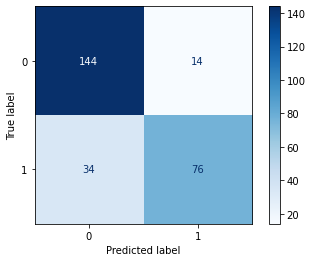

In [158]:
plot_confusion_matrix(voting_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

Let's save the Voting Classifier to a file.

In [159]:
dump(voting_model, 'models/voting_model.joblib');

## Metrics

Let's gather all the models we have built and see how their classification metrics look.

In [166]:
from sklearn import metrics
model_name = []
accuracy_score = []
cv_score = []
    
def metrics_models(name, model):
    models = list()
    models.append((name, model))
    
    for name, model in models:
        model_name.append(name)
        accuracy_score.append(metrics.accuracy_score(model.predict(X_test), y_test))
        cv_score.append(cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean())

In [167]:
metrics_models('Base GaussianNB', basemodel1)
metrics_models('Base MultinomialNB', basemodel2)
metrics_models('Base LinearRegression', lr_baseline)
metrics_models('Base SVM', svm_baseline)
metrics_models('DecisionTreeClassifier', tree_model)
metrics_models('RandomForestClassifier', forest_model)
metrics_models('KNeighborsClassifier', knn_model)
metrics_models('Bagging_KNeighborsClassifier', bagging_knn_model)
metrics_models('Bagging_DecisionTreeClassifier', bagging_DT_model)
metrics_models('AdaBoostClassifier', ada_model)
metrics_models('XGBoostClassifier', xgb_model)
metrics_models('VotingClassifier', voting_model)
metrics_models('StackingClassifier', stacking_model)

In [168]:
metrics_df = pd.DataFrame({'Model': model_name,
                           'Accuracy': accuracy_score,
                           'Cross validation': cv_score,
                           })

In [169]:
metrics_df = metrics_df.sort_values(['Cross validation', 'Accuracy'], ascending=False).reset_index(drop=True)
metrics_df

,Model,Accuracy,Cross validation
0,VotingClassifier,0.820896,0.836180
1,RandomForestClassifier,0.820896,0.831685
2,StackingClassifier,0.824627,0.831673
3,Base SVM,0.828358,0.831648
4,KNeighborsClassifier,0.820896,0.826030
5,Bagging_DecisionTreeClassifier,0.824627,0.824956
6,Base LinearRegression,0.832090,0.824919
7,DecisionTreeClassifier,0.832090,0.823845
8,Bagging_KNeighborsClassifier,0.802239,0.822659
9,XGBoostClassifier,0.824627,0.817066


Let's visualize the results on a chart.

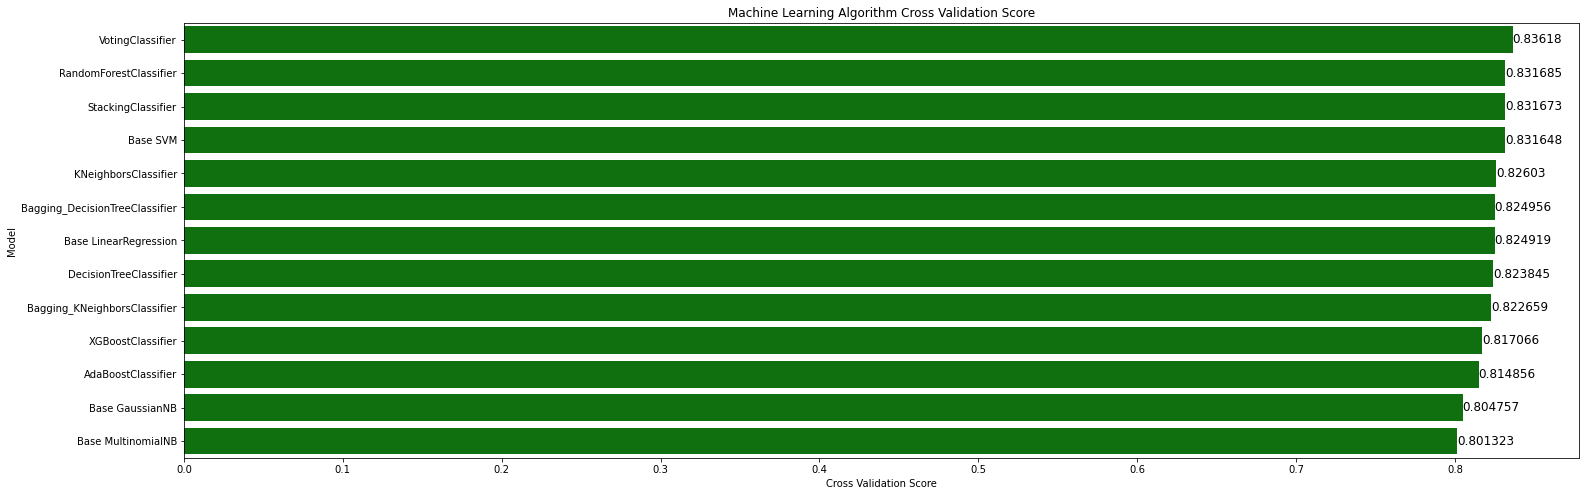

In [250]:
fig = plt.subplots(figsize=(25,8))

ax = sns.barplot(x='Cross validation', y = 'Model', data = metrics_df, color = 'g')
plt.title('Machine Learning Algorithm Cross Validation Score')
plt.xlabel('Cross Validation Score')
plt.ylabel('Model')

for container in ax.containers:
    plt.bar_label(container, fontsize=12);

plt.show()

### Producing the results file

After ranking the results of our models based on accuracy and cross-validation scores, we see that our best performing model is the Voting Classifier. Let's now apply this model to predict whether a given masseur survived the disaster.

In [270]:
y_pred = voting_model.predict(X)

Let's compare our predictions with the actual information about whether each passenger survived the Titanic disaster.

In [271]:
results_df = pd.DataFrame(y_pred, index=X.index, columns=['Predicted'])
results_df['Survived'] = y['Survived'] 
results_df = results_df.reset_index()
results_df = results_df.rename(columns={"index": "PassengerId"}) #, "Predicted": "Predicted", "Survived": "Survived"
results_df

,PassengerId,Predicted,Survived
0,0,0,0
1,1,1,1
2,2,0,1
3,3,1,1
4,4,0,0
...,...,...,...
886,886,0,0
887,887,1,1
888,888,0,0
889,889,0,1


Let's save our result to a separate CSV file.

In [272]:
# Generate Results File 
results_df.to_csv("results/results.csv", index=False)

## Conclusions

These results show the accuracy and cross-validation scores for each model. The accuracy represents how well each model performed on the test set, while cross-validation provides an estimate of the model's performance on unseen data. The higher the values, the better the model's performance.

Based on the results from various classifiers for the Titanic disaster project, the following conclusions can be drawn:

1. **Best Models**:
    - Models based on VotingClassifier, RandomForestClassifier, and SVM (Base SVM) achieved high accuracy levels around 82-83%. These three models stand out with the best performance in both accuracy and cross-validation.
    - StackingClassifier, Base LinearRegression, and DecisionTreeClassifier also achieved accuracy above 82%, demonstrating good performance.
    

2. **Models with Lower Accuracy**:
   - Bagging_KNeighborsClassifier, XGBoostClassifier, and AdaBoostClassifier achieved accuracy below 82%, indicating potentially lower effectiveness compared to the top-performing models.
   - Base GaussianNB and Base MultinomialNB achieved the lowest accuracy, below 81%.
   

3. **Model Stability**:
   - Ensemble-based models such as VotingClassifier, StackingClassifier, and RandomForestClassifier proved to be stable and less sensitive to variations in training data, as evidenced by their high cross-validation scores.
   

4. **Potential Next Steps**:
   - Consider further optimizing the best-performing models (e.g., fine-tuning hyperparameters) to potentially improve their accuracy.
   - Explore the use of other advanced ensemble techniques, such as Boosting, to compare their performance with the Bagging model.
   

5. **Interpreting Results**:
   - Conduct a more detailed analysis of the results to understand which features are most significant for each model and how different models respond to various aspects of the data.

In summary, while the VotingClassifier, RandomForestClassifier, and Base SVM models achieved the best results, there is still room for further optimization and exploration of other modeling techniques to achieve even better predictive performance for this problem.